# Total Spend Prediction — Regression Modeling

This notebook implements and compares a broad set of regression models to predict **TotalSpend**. Rather than focusing on a single modeling approach, the analysis follows a structured progression across multiple model families in order to evaluate different assumptions, levels of complexity, and inductive biases.

In total, **20 regression models** are trained and evaluated. These models are not random variants, but are intentionally grouped into coherent categories, each serving a specific analytical purpose. Some models act as simple baselines, others explore non-linear feature interactions, and more advanced ensemble methods are included to assess potential performance gains.

The modeling workflow is learning-oriented and exploratory by design. While not all models are intended for final deployment, each contributes to understanding the trade-offs between interpretability, flexibility, and generalization performance. All preprocessing steps are applied in a leakage-safe manner, with parameters fitted exclusively on the training data.

The evaluated models are organized into the following categories:

---

## 1. Linear and Regularized Linear Models (Models 1–6)

This group establishes baseline performance and emphasizes interpretability. It includes ordinary least squares regression and regularized variants designed to address multicollinearity and reduce model complexity.

- Baseline linear regression with different feature sets  
- Ridge regression for coefficient shrinkage  
- Lasso-based models for feature selection and sparsity  
- Linear regression trained on Lasso-selected features  

These models provide a reference point for assessing the added value of more complex approaches.

---

## 2. Polynomial Regression Models (Models 7–11)

Polynomial models extend linear regression by incorporating second-degree feature interactions. Both full and regularized variants are explored to balance expressive power and overfitting risk.

- Polynomial linear regression (degree 2)  
- Polynomial Ridge and Lasso models  
- Feature-selected polynomial models  

This group evaluates whether non-linear relationships substantially improve predictive performance.

---

## 3. Decision Tree Models (Models 12–15)

Single regression trees are used to capture complex non-linear patterns without explicit feature transformations.

- Fully grown regression tree (overfitting reference)  
- Hyperparameter-tuned regression tree  
- Cost-complexity pruned trees  

These models illustrate the trade-off between model flexibility and generalization.

---

## 4. Ensemble Tree-Based Models (Models 16–19)

Ensemble methods combine multiple decision trees to improve robustness and predictive accuracy.

- Random Forest (baseline and tuned)  
- Gradient Boosting regression  
- Tuned XGBoost regressor  

These models represent the most flexible and high-performing approaches evaluated in this notebook.

---

## 5. Kernel-Based Model (Model 20-21)

Support Vector Regression (SVR) with an RBF kernel is included as a distance-based, non-linear modeling alternative.

- SVR trained on a reduced feature set selected via Lasso  

This model provides a contrast to tree-based ensembles and polynomial approaches.

---

Overall, the model comparison highlights how predictive performance evolves as model complexity increases, and which modeling strategies offer the best balance between accuracy and generalization for TotalSpend prediction.


In [1]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# ============================================================
# 📐 Statistics & Statistical Modeling
# ============================================================
import scipy.stats as stats
import statsmodels.api as sm

# ============================================================
# 🤖 Machine Learning — Core Utilities
# ============================================================
from sklearn.model_selection import (KFold, cross_val_score, GridSearchCV, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, PolynomialFeatures)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

# ============================================================
# 📈 Linear & Regularized Models
# ============================================================
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV)

# ============================================================
# 🌳 Tree-Based Models
# ============================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

# ============================================================
# 🌊 Kernel-Based Models
# ============================================================
from sklearn.svm import SVR

# ============================================================
# 🚀 Gradient Boosting (External)
# ============================================================
from xgboost import XGBRegressor

# ============================================================
# 🚨 Anomaly Detection (used in EDA / preprocessing)
# ============================================================
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling
# ============================================================
MAIN_COLOR = "#B388EB"


ModuleNotFoundError: No module named 'statsmodels'

## 1. Data Preparation and Feature Construction for Modeling
This section describes the data preparation workflow applied prior to model training. The goal is to construct a modeling-ready dataset while strictly preventing information leakage.

Feature construction follows a clear separation between deterministic features and distribution-dependent transformations. Deterministic features that do not rely on the data distribution are created before the train–test split. All anomaly detection and transformation steps that require estimating distributional statistics are applied only after the split and are fitted exclusively on the training data.

The overall workflow follows the sequence below:

1. Load raw data

2. Apply basic data cleaning
   - Type corrections (Dt_Customer)
   - Trivial missing (Income median)

3. Construct deterministic features (SAFE)
   - Age
   - Marital_Status (cleaned)
   - FamilySize
   - HasChildren
   - Tenure_Days
   - Tenure_Months
   - Education_Level
   - Education_Level_Grouped
   - TotalSpend
   - TotalAccepted

4. Perform Train / Test split  ⭐  

5. Fit IQR-based anomaly detection on the training data 
   - IQR bounds for Income

6. Apply anomaly treatment consistently to both training and test sets
   - Income_capped (train)
   - apply SAME bounds → test

7. Apply Feature Transformations (fitted on TRAIN data)
   - TotalSpend_log (target)

8. Proceed to model training and evaluation


### 1.1 Load Raw Data

In [2]:
# Load raw marketing campaign dataset
df = pd.read_csv('Data/marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 1.2 Basic Data Cleaning

In [3]:
# ----------------------------------
# 1.2 Basic Data Cleaning
# ----------------------------------

# Convert customer registration date to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Median imputation for Income
income_median = df['Income'].median()
df['Income'] = df['Income'].fillna(income_median)

# Check remaining missing values in Income
df['Income'].isna().sum()


np.int64(0)

- Median imputation for Income is applied as a basic data cleaning step to handle trivial missing values. All distribution-sensitive preprocessing steps, including anomaly detection and feature transformations, are deferred to later stages and fitted exclusively on the training data.


### 1.3 Deterministic Feature Engineering (SAFE)
At this stage, `df` contains the raw dataset with basic cleaning applied.

In [553]:
# ----------------------------------
# 1.3 Deterministic Feature Engineering
# ----------------------------------

# Make a copy to keep transformations explicit
#df = df.copy()

# -------------------------------
# Temporal features
# -------------------------------
reference_year = df['Dt_Customer'].dt.year.max()
reference_date = df['Dt_Customer'].max()

# Age (to be checked later for anomalies)
df['Age'] = reference_year - df['Year_Birth']

# Customer tenure
df['Tenure_Days'] = (reference_date - df['Dt_Customer']).dt.days
df['Tenure_Months'] = (df['Tenure_Days'] / 30).round().astype(int)

# -------------------------------
# Household & demographic features
# -------------------------------
# Group rare marital status categories
df['Marital_Status'] = df['Marital_Status'].replace(
    ['Alone', 'Absurd', 'YOLO'],
    'Other'
)

# Binary indicator for children
df['HasChildren'] = ((df['Kidhome'] + df['Teenhome']) > 0).astype(int)

# Household size (adults + children)
df['FamilySize'] = (
    df['Marital_Status'].isin(['Married', 'Together']).astype(int) + 1
    + df['Kidhome']
    + df['Teenhome']
)

# -------------------------------
# Education features
# -------------------------------
education_map = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

df['Education_Level'] = df['Education'].map(education_map)

df['Education_Level_Grouped'] = pd.cut(
    df['Education_Level'],
    bins=[0, 2, 4, 5],
    labels=['Low', 'Medium', 'High']
)

# -------------------------------
# Spending & campaign behavior
# -------------------------------
spend_cols = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds'
]

df['TotalSpend'] = df[spend_cols].sum(axis=1)

purchase_cols = [
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases'
]

df['TotalPurchases'] = df[purchase_cols].sum(axis=1)

accepted_cols = [
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5'
]

df['TotalAccepted'] = df[accepted_cols].sum(axis=1)

# Quick sanity check
df[['Age', 'FamilySize', 'Tenure_Days', 'TotalSpend', 'TotalAccepted']].head()


,Age,FamilySize,Tenure_Days,TotalSpend,TotalAccepted
0,57,1,663,1617,0
1,60,3,113,27,0
2,49,2,312,776,0
3,30,3,139,53,0
4,33,3,161,422,0


### 1.4 Train / Test Split

In [554]:
# ----------------------------------
# 1.4 Train / Test Split
# ----------------------------------

from sklearn.model_selection import train_test_split

# Define target (raw scale)
y = df['TotalSpend']

# Define feature matrix
X = df.drop(columns=['TotalSpend'])

# Perform train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42
)

# Sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1792, 38), (448, 38), (1792,), (448,))

- The dataset is split using the raw target variable. The logarithmic transformation of the target is applied after the split to ensure a consistent and leakage-safe preprocessing workflow.


### 1.5 IQR-Based Anomaly Detection and Capping (Training Data Only)
In this step, IQR-based anomaly detection is applied exclusively on the training data. The resulting bounds are then consistently applied to both training and test sets to prevent information leakage.


In [555]:
# ----------------------------------
# 1.5 IQR-Based Anomaly Detection
# ----------------------------------

def fit_iqr_bounds(series, k=1.5):
    """
    Fit IQR bounds on a training series.
    Returns lower and upper bounds.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    return lower, upper


def apply_iqr_capping(series, lower, upper):
    """
    Apply pre-fitted IQR bounds to a series.
    """
    return series.clip(lower=lower, upper=upper)


# -------------------------------
# Fit bounds on TRAIN only
# -------------------------------
income_lb, income_ub = fit_iqr_bounds(X_train['Income'], k=3.0)
age_lb, age_ub = fit_iqr_bounds(X_train['Age'], k=1.5)

# -------------------------------
# Apply capping
# -------------------------------
X_train['Income_capped'] = apply_iqr_capping(
    X_train['Income'], income_lb, income_ub
)

X_test['Income_capped'] = apply_iqr_capping(
    X_test['Income'], income_lb, income_ub
)

X_train['Age_capped'] = apply_iqr_capping(
    X_train['Age'], age_lb, age_ub
)

X_test['Age_capped'] = apply_iqr_capping(
    X_test['Age'], age_lb, age_ub
)

# -------------------------------
# Sanity check
# -------------------------------
print("Income bounds (3×IQR):", income_lb, income_ub)
print("Age bounds (1.5×IQR):", age_lb, age_ub)


Income bounds (3×IQR): -62949.75 165892.5
Age bounds (1.5×IQR): 7.5 83.5


In [556]:
X_train.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Tenure_Days', 'Tenure_Months', 'HasChildren', 'FamilySize',
       'Education_Level', 'Education_Level_Grouped', 'TotalPurchases',
       'TotalAccepted', 'Income_capped', 'Age_capped'],
      dtype='object')

### 1.6 Target Transformation (Log Scale)
In this step, the target variable is transformed to the logarithmic scale to address skewness and stabilize variance. No logarithmic transformation is applied to input features.

In [558]:
# ----------------------------------
# 1.6 Target Transformation
# ----------------------------------

# Log-transform target (applied after split)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Sanity check
y_train_log.describe(), y_test_log.describe()


(count    1792.000000
 mean        5.588220
 std         1.480831
 min         1.791759
 25%         4.204693
 50%         5.913503
 75%         6.941190
 max         7.834392
 Name: TotalSpend, dtype: float64,
 count    448.000000
 mean       5.749357
 std        1.422820
 min        1.945910
 25%        4.403652
 50%        6.087905
 75%        7.008729
 max        7.834392
 Name: TotalSpend, dtype: float64)

## 2. Framework and Evaluation Setup

In [573]:
# ============================================
# 📊 Regression Model Logger — Behavioral
# ============================================

behavioral_log = []

def log_behavioral_model(
    name,
    r2_train,
    r2_test,
    mse_train,
    mse_test,
    r2_cv=None,
    feature_count=None,
    notes=None
):
    global behavioral_log

    behavioral_log.append({
        "Model": name,
        "R²_train": round(r2_train, 3),
        "R²_test": round(r2_test, 3),
        "R²_CV": round(r2_cv, 3) if r2_cv is not None else None,
        "MSE_train": round(mse_train, 2),
        "MSE_test": round(mse_test, 2),
        "Feature_count": feature_count,
        "Notes": notes
    })


def get_behavioral_summary(sort_by="R²_test", ascending=False):
    df = pd.DataFrame(behavioral_log)
    if not df.empty and sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=ascending, ignore_index=True)
    return df


In [574]:
# ============================================
# 📊 Regression Model Logger — Profile-only
# ============================================

profile_log = []

def log_profile_model(
    name,
    r2_train,
    r2_test,
    mse_train,
    mse_test,
    r2_cv=None,
    feature_count=None,
    notes=None
):
    global profile_log

    profile_log.append({
        "Model": name,
        "R²_train": round(r2_train, 3),
        "R²_test": round(r2_test, 3),
        "R²_CV": round(r2_cv, 3) if r2_cv is not None else None,
        "MSE_train": round(mse_train, 2),
        "MSE_test": round(mse_test, 2),
        "Feature_count": feature_count,
        "Notes": notes
    })


def get_profile_summary(sort_by="R²_test", ascending=False):
    df = pd.DataFrame(profile_log)
    if not df.empty and sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=ascending, ignore_index=True)
    return df


## 3. Baseline Regression Models

### Model 1 — Linear Regression (Baseline)

This model is evaluated under two feature scenarios:
- Behavioral feature set (upper-bound benchmark)
- Customer profile feature set (realistic predictive scenario)


#### 🔹 Variant A — Profile + Behavioral feature set

In [575]:
# ============================================================
# Model 1 — Linear Regression
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m1 = X_train[num_cols + cat_cols]
X_test_m1  = X_test[num_cols + cat_cols]

y_train_m1 = y_train_log
y_test_m1  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_lr = Pipeline(
    [
        ("pre", preprocessor),
        ("lr", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr, X_train_m1, y_train_m1, cv=cv, scoring="r2"
).mean()

pipe_lr.fit(X_train_m1, y_train_m1)

y_train_pred = pipe_lr.predict(X_train_m1)
y_test_pred  = pipe_lr.predict(X_test_m1)

r2_train = r2_score(y_train_m1, y_train_pred)
r2_test  = r2_score(y_test_m1, y_test_pred)
mse_train = mean_squared_error(y_train_m1, y_train_pred)
mse_test  = mean_squared_error(y_test_m1, y_test_pred)

encoder = pipe_lr.named_steps["pre"].transformers_[1][1]
cat_feature_counts = [len(c) - 1 for c in encoder.categories_]
feature_count = len(num_cols) + sum(cat_feature_counts)

log_behavioral_model(
    name="Model 1 — Linear Regression(Baseline)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_test=mse_test,
    mse_train=mse_train,
    feature_count=feature_count,
    notes="Behavioral purchase variables (upper-bound benchmark)"
)

print("Model 1 — Linear Regression(Baseline)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 1 — Linear Regression(Baseline)
R² test : 0.879
R² train: 0.876
R² CV   : 0.867


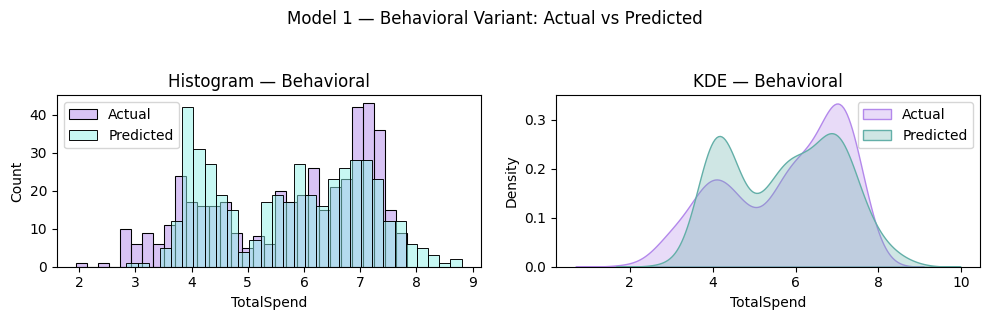

In [576]:
# ============================================================
# Model 1 — Behavioral Variant
# Actual vs Predicted (Test Set)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram
sns.histplot(
    y_test_m1,
    label="Actual",
    color="#B388EB",
    bins=30,
    alpha=0.5,
    ax=axes[0]
)
sns.histplot(
    y_test_pred,
    label="Predicted",
    color="#91F3E9FF",
    bins=30,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("Histogram — Behavioral")
axes[0].legend()

# KDE
sns.kdeplot(
    y_test_m1,
    label="Actual",
    color="#B388EB",
    fill=True,
    alpha=0.3,
    ax=axes[1]
)
sns.kdeplot(
    y_test_pred,
    label="Predicted",
    color="#63AFA8FF",
    fill=True,
    alpha=0.3,
    ax=axes[1]
)
axes[1].set_title("KDE — Behavioral")
axes[1].legend()

plt.suptitle("Model 1 — Behavioral Variant: Actual vs Predicted", y=1.05)
plt.tight_layout()
plt.show()


#### 🔹 Variant B — Profile-only feature set

In [577]:
# ============================================================
# Model 1 — Linear Regression
# Variant B: Customer profile only
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m1 = X_train[num_cols + cat_cols]
X_test_m1  = X_test[num_cols + cat_cols]

y_train_m1 = y_train_log
y_test_m1  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_lr = Pipeline(
    [
        ("pre", preprocessor),
        ("lr", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr, X_train_m1, y_train_m1, cv=cv, scoring="r2"
).mean()

pipe_lr.fit(X_train_m1, y_train_m1)

y_train_pred = pipe_lr.predict(X_train_m1)
y_test_pred  = pipe_lr.predict(X_test_m1)

r2_train = r2_score(y_train_m1, y_train_pred)
r2_test  = r2_score(y_test_m1, y_test_pred)
mse_train = mean_squared_error(y_train_m1, y_train_pred)
mse_test  = mean_squared_error(y_test_m1, y_test_pred)

encoder = pipe_lr.named_steps["pre"].transformers_[1][1]
cat_feature_counts = [len(c) - 1 for c in encoder.categories_]
feature_count = len(num_cols) + sum(cat_feature_counts)

log_profile_model(
    name="Model 1 — Linear Regression(Baseline)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_test=mse_test,
    mse_train=mse_train,
    feature_count=feature_count,
    notes="Customer profile features only (leakage-safe)"
)

print("Model 1 — Linear Regression(Baseline)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 1 — Linear Regression(Baseline)
R² test : 0.671
R² train: 0.669
R² CV   : 0.663


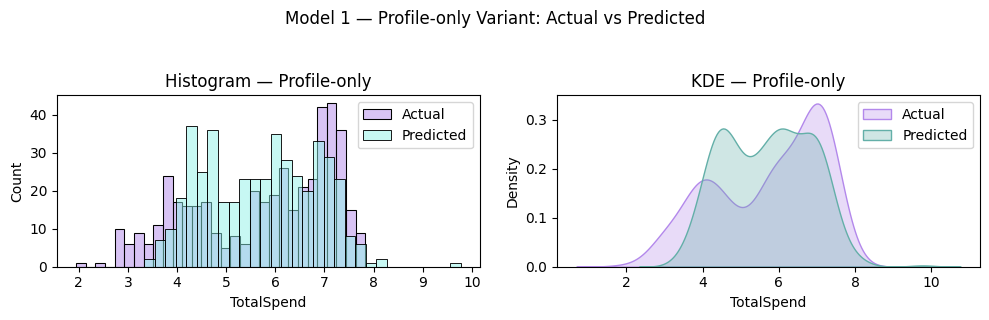

In [578]:
# ============================================================
# Model 1 — Profile-only Variant
# Actual vs Predicted (Test Set)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram
sns.histplot(
    y_test_m1,
    label="Actual",
    color="#B388EB",
    bins=30,
    alpha=0.5,
    ax=axes[0]
)
sns.histplot(
    y_test_pred,
    label="Predicted",
    color="#91F3E9FF",
    bins=30,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title("Histogram — Profile-only")
axes[0].legend()

# KDE
sns.kdeplot(
    y_test_m1,
    label="Actual",
    color="#B388EB",
    fill=True,
    alpha=0.3,
    ax=axes[1]
)
sns.kdeplot(
    y_test_pred,
    label="Predicted",
    color="#63AFA8FF",
    fill=True,
    alpha=0.3,
    ax=axes[1]
)
axes[1].set_title("KDE — Profile-only")
axes[1].legend()

plt.suptitle("Model 1 — Profile-only Variant: Actual vs Predicted", y=1.05)
plt.tight_layout()
plt.show()


### Model 2 — Linear Regression (EDA-based Features)

This model uses a reduced set of features selected based on EDA insights.
It is evaluated under two scenarios:
- Behavioral feature set (EDA-based upper-bound benchmark)
- Customer profile feature set (EDA-based realistic scenario)

#### 🔹 Variant A — Profile + Behavioral feature set

In [579]:
# ============================================================
# Model 2 — Linear Regression
# Behavioral variant (EDA-based features)
# ============================================================

num_cols = [
    "Income_capped",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebPurchases",
    "NumWebVisitsMonth",
    "Kidhome",
    "Tenure_Days",
    "Age_capped"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "AcceptedCmp5",
    "AcceptedCmp1",
    "AcceptedCmp4",
    "Response"
]

X_train_m2 = X_train[num_cols + cat_cols]
X_test_m2  = X_test[num_cols + cat_cols]

y_train_m2 = y_train_log
y_test_m2  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_lr = Pipeline(
    [
        ("pre", preprocessor),
        ("lr", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr, X_train_m2, y_train_m2, cv=cv, scoring="r2"
).mean()

pipe_lr.fit(X_train_m2, y_train_m2)

y_train_pred = pipe_lr.predict(X_train_m2)
y_test_pred  = pipe_lr.predict(X_test_m2)

r2_train = r2_score(y_train_m2, y_train_pred)
r2_test  = r2_score(y_test_m2, y_test_pred)
mse_train = mean_squared_error(y_train_m2, y_train_pred)
mse_test  = mean_squared_error(y_test_m2, y_test_pred)

encoder = pipe_lr.named_steps["pre"].transformers_[1][1]
feature_count = len(num_cols) + sum(len(c) - 1 for c in encoder.categories_)

log_behavioral_model(
    name="Model 2 — Linear Regression (EDA-based features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="EDA-based behavioral feature selection"
)

print("Model 2 — Linear Regression variant (EDA-based features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 2 — Linear Regression variant (EDA-based features)
R² test : 0.863
R² train: 0.864
R² CV   : 0.856


#### 🔹 Variant B — Profile-only feature set

In [580]:
# ============================================================
# Model 2 — Linear Regression
# Profile-only variant (EDA-based features)
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    #"Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status",
]

X_train_m2 = X_train[num_cols + cat_cols]
X_test_m2  = X_test[num_cols + cat_cols]

y_train_m2 = y_train_log
y_test_m2  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_lr = Pipeline(
    [
        ("pre", preprocessor),
        ("lr", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr, X_train_m2, y_train_m2, cv=cv, scoring="r2"
).mean()

pipe_lr.fit(X_train_m2, y_train_m2)

y_train_pred = pipe_lr.predict(X_train_m2)
y_test_pred  = pipe_lr.predict(X_test_m2)

r2_train = r2_score(y_train_m2, y_train_pred)
r2_test  = r2_score(y_test_m2, y_test_pred)
mse_train = mean_squared_error(y_train_m2, y_train_pred)
mse_test  = mean_squared_error(y_test_m2, y_test_pred)

encoder = pipe_lr.named_steps["pre"].transformers_[1][1]
feature_count = len(num_cols) + sum(len(c) - 1 for c in encoder.categories_)

log_profile_model(
    name="Model 2 — Linear Regression (EDA-based features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="EDA-based profile feature selection"
)

print("Model 2 — Linear Regression (EDA-based features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 2 — Linear Regression (EDA-based features)
R² test : 0.671
R² train: 0.668
R² CV   : 0.663


### Model 3 — Ridge Regression (Regularized Linear Model)

This model extends linear regression by applying L2 regularization (Ridge)
to mitigate multicollinearity and improve coefficient stability.

The model is evaluated under two feature scenarios:
- Behavioral feature set (upper-bound benchmark)
- Customer profile feature set (realistic predictive scenario)



#### 🔹 Variant A — Profile + Behavioral feature set


In [581]:
# ============================================================
# Model 3 — Ridge Regression
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m3 = X_train[num_cols + cat_cols]
X_test_m3  = X_test[num_cols + cat_cols]

y_train_m3 = y_train_log
y_test_m3  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alphas = np.logspace(-3, 3, 50)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = RidgeCV(alphas=alphas, cv=cv_inner, scoring="r2")

pipe_ridge = Pipeline(
    [
        ("pre", preprocessor),
        ("ridge", ridge)
    ]
)

pipe_ridge.fit(X_train_m3, y_train_m3)

y_train_pred = pipe_ridge.predict(X_train_m3)
y_test_pred  = pipe_ridge.predict(X_test_m3)

r2_train = r2_score(y_train_m3, y_train_pred)
r2_test  = r2_score(y_test_m3, y_test_pred)
mse_train = mean_squared_error(y_train_m3, y_train_pred)
mse_test  = mean_squared_error(y_test_m3, y_test_pred)

cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_ridge, X_train_m3, y_train_m3, cv=cv_outer, scoring="r2"
).mean()

encoder = pipe_ridge.named_steps["pre"].transformers_[1][1]
feature_count = len(num_cols) + sum(len(c) - 1 for c in encoder.categories_)

log_behavioral_model(
    name="Model 3 — Ridge Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="All behavioral features, Ridge regularization"
)

print("Model 3 — Ridge Regression")
print(f"Best α  : {pipe_ridge.named_steps['ridge'].alpha_:.5f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 3 — Ridge Regression
Best α  : 79.06043
R² test : 0.881
R² train: 0.875
R² CV   : 0.868


#### 🔹 Variant B — Profile-only feature set

In [582]:
# ============================================================
# Model 3 — Ridge Regression
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m3 = X_train[num_cols + cat_cols]
X_test_m3  = X_test[num_cols + cat_cols]

y_train_m3 = y_train_log
y_test_m3  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alphas = np.logspace(-3, 3, 50)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = RidgeCV(alphas=alphas, cv=cv_inner, scoring="r2")

pipe_ridge = Pipeline(
    [
        ("pre", preprocessor),
        ("ridge", ridge)
    ]
)

pipe_ridge.fit(X_train_m3, y_train_m3)

y_train_pred = pipe_ridge.predict(X_train_m3)
y_test_pred  = pipe_ridge.predict(X_test_m3)

r2_train = r2_score(y_train_m3, y_train_pred)
r2_test  = r2_score(y_test_m3, y_test_pred)
mse_train = mean_squared_error(y_train_m3, y_train_pred)
mse_test  = mean_squared_error(y_test_m3, y_test_pred)

cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_ridge, X_train_m3, y_train_m3, cv=cv_outer, scoring="r2"
).mean()

encoder = pipe_ridge.named_steps["pre"].transformers_[1][1]
feature_count = len(num_cols) + sum(len(c) - 1 for c in encoder.categories_)

log_profile_model(
    name="Model 3 — Ridge Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Profile-only features, Ridge regularization"
)

print("Model 3 — Ridge Regression")
print(f"Best α  : {pipe_ridge.named_steps['ridge'].alpha_:.5f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 3 — Ridge Regression
Best α  : 44.98433
R² test : 0.670
R² train: 0.668
R² CV   : 0.664


### Model 4 — Lasso Regression (Automatic Feature Selection)

This model applies L1 regularization (Lasso) to automatically select a sparse
set of informative features by shrinking less relevant coefficients to zero.

The model is evaluated under two feature scenarios:
- Behavioral feature set (upper-bound benchmark)
- Customer profile feature set (realistic predictive scenario)


#### 🔹 Variant A — Profile + Behavioral feature set

In [583]:
# ============================================================
# Model 4 — LassoCV
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m4 = X_train[num_cols + cat_cols]
X_test_m4  = X_test[num_cols + cat_cols]

y_train_m4 = y_train_log
y_test_m4  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alphas = np.logspace(-4, 1, 50)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)

lasso = LassoCV(
    alphas=alphas,
    cv=cv_inner,
    max_iter=50000,
    random_state=42
)

pipe_lasso = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso)
    ]
)

# ----------------------------
# Fit model
# ----------------------------
pipe_lasso.fit(X_train_m4, y_train_m4)

# ----------------------------
# Predictions & metrics
# ----------------------------
y_train_pred = pipe_lasso.predict(X_train_m4)
y_test_pred  = pipe_lasso.predict(X_test_m4)

r2_train = r2_score(y_train_m4, y_train_pred)
r2_test  = r2_score(y_test_m4, y_test_pred)
mse_train = mean_squared_error(y_train_m4, y_train_pred)
mse_test  = mean_squared_error(y_test_m4, y_test_pred)

cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso, X_train_m4, y_train_m4, cv=cv_outer, scoring="r2"
).mean()

# ----------------------------
# Selected features (NON-ZERO)
# ----------------------------
feature_names = pipe_lasso.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso.named_steps["lasso"].coef_

selected = [
    (name, coef)
    for name, coef in zip(feature_names, coefs)
    if coef != 0
]

selected_sorted = sorted(
    selected, key=lambda x: abs(x[1]), reverse=True
)

n_selected = len(selected_sorted)

# ----------------------------
# Logging
# ----------------------------
log_behavioral_model(
    name="Model 4 — LassoCV",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=n_selected,
    notes="Behavioral features, L1 regularization"
)

# ----------------------------
# Report
# ----------------------------
print("Model 4 — LassoCV")
print(f"Best α  : {pipe_lasso.named_steps['lasso'].alpha_:.6f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"\nSelected features: {n_selected} / {len(feature_names)}")

for name, coef in selected_sorted:
    print(f"  {name:45s}  coef = {coef:+.4f}")


Model 4 — LassoCV
Best α  : 0.001048
R² test : 0.880
R² train: 0.876
R² CV   : 0.867

Selected features: 24 / 27
  num__NumWebPurchases                           coef = +0.3826
  num__Income_capped                             coef = +0.3734
  num__NumStorePurchases                         coef = +0.3618
  num__NumCatalogPurchases                       coef = +0.3216
  cat__AcceptedCmp4_1                            coef = +0.2573
  num__Kidhome                                   coef = -0.2223
  num__NumDealsPurchases                         coef = +0.1851
  cat__Complain_1                                coef = -0.1392
  num__Teenhome                                  coef = -0.1229
  cat__Response_1                                coef = +0.1131
  num__Tenure_Days                               coef = +0.0945
  cat__AcceptedCmp3_1                            coef = +0.0766
  cat__Marital_Status_Widow                      coef = +0.0703
  cat__Marital_Status_Single                     coef =

#### 🔹 Variant B — Profile-only feature set

In [584]:
# ============================================================
# Model 4 — LassoCV
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m4 = X_train[num_cols + cat_cols]
X_test_m4  = X_test[num_cols + cat_cols]

y_train_m4 = y_train_log
y_test_m4  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alphas = np.logspace(-4, 1, 50)
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)

lasso = LassoCV(
    alphas=alphas,
    cv=cv_inner,
    max_iter=50000,
    random_state=42
)

pipe_lasso = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso)
    ]
)

# ----------------------------
# Fit model
# ----------------------------
pipe_lasso.fit(X_train_m4, y_train_m4)

# ----------------------------
# Predictions & metrics
# ----------------------------
y_train_pred = pipe_lasso.predict(X_train_m4)
y_test_pred  = pipe_lasso.predict(X_test_m4)

r2_train = r2_score(y_train_m4, y_train_pred)
r2_test  = r2_score(y_test_m4, y_test_pred)
mse_train = mean_squared_error(y_train_m4, y_train_pred)
mse_test  = mean_squared_error(y_test_m4, y_test_pred)

cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso, X_train_m4, y_train_m4, cv=cv_outer, scoring="r2"
).mean()

# ----------------------------
# Selected features (NON-ZERO)
# ----------------------------
feature_names = pipe_lasso.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso.named_steps["lasso"].coef_

selected = [
    (name, coef)
    for name, coef in zip(feature_names, coefs)
    if coef != 0
]

selected_sorted = sorted(
    selected, key=lambda x: abs(x[1]), reverse=True
)

n_selected = len(selected_sorted)

# ----------------------------
# Logging
# ----------------------------
log_profile_model(
    name="Model 4 — LassoCV",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=n_selected,
    notes="Profile-only features, L1 regularization"
)

# ----------------------------
# Report
# ----------------------------
print("Model 4 — LassoCV")
print(f"Best α  : {pipe_lasso.named_steps['lasso'].alpha_:.6f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"\nSelected features: {n_selected} / {len(feature_names)}")

for name, coef in selected_sorted:
    print(f"  {name:45s}  coef = {coef:+.4f}")


Model 4 — LassoCV
Best α  : 0.013895
R² test : 0.672
R² train: 0.667
R² CV   : 0.666

Selected features: 5 / 13
  num__Income_capped                             coef = +0.9150
  num__Kidhome                                   coef = -0.4301
  num__Teenhome                                  coef = -0.0316
  num__Age_capped                                coef = -0.0058
  cat__Education_Graduation                      coef = +0.0029


### Model 5 — Lasso Regression (Fixed Alpha)

This model applies L1 regularization with a fixed regularization strength (α),
selected based on the results of LassoCV.  
Fixing α allows for a more stable and interpretable sparse solution.

The model is evaluated under two feature scenarios:
- Behavioral feature set (upper-bound benchmark)
- Customer profile feature set (realistic predictive scenario)


#### 🔹 Variant A — Profile + Behavioral feature set

In [585]:
# ============================================================
# Model 5 — Lasso Regression (Fixed Alpha)
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m5 = X_train[num_cols + cat_cols]
X_test_m5  = X_test[num_cols + cat_cols]

y_train_m5 = y_train_log
y_test_m5  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alpha_fixed = 0.03   # chosen based on LassoCV results

lasso_fixed = Lasso(
    alpha=alpha_fixed,
    max_iter=50000,
    random_state=42
)

pipe_lasso_fixed = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso_fixed)
    ]
)

# ----------------------------
# Fit model
# ----------------------------
pipe_lasso_fixed.fit(X_train_m5, y_train_m5)

# ----------------------------
# Predictions & metrics
# ----------------------------
y_train_pred = pipe_lasso_fixed.predict(X_train_m5)
y_test_pred  = pipe_lasso_fixed.predict(X_test_m5)

r2_train = r2_score(y_train_m5, y_train_pred)
r2_test  = r2_score(y_test_m5, y_test_pred)
mse_train = mean_squared_error(y_train_m5, y_train_pred)
mse_test  = mean_squared_error(y_test_m5, y_test_pred)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso_fixed, X_train_m5, y_train_m5, cv=cv, scoring="r2"
).mean()

# ----------------------------
# Selected features
# ----------------------------
feature_names = pipe_lasso_fixed.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_fixed.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if c != 0]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
n_selected = len(selected_sorted)

# ----------------------------
# Logging
# ----------------------------
log_behavioral_model(
    name="Model 5 — LassoCV (Fixed Alpha)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=n_selected,
    notes="Behavioral features, fixed alpha from LassoCV"
)

# ----------------------------
# Report
# ----------------------------
print("Model 5 — LassoCV (Fixed Alpha)")
print(f"Alpha fixed: {alpha_fixed}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"\nSelected features: {n_selected}")

for name, coef in selected_sorted:
    print(f"  {name:45s}  coef = {coef:+.4f}")


Model 5 — LassoCV (Fixed Alpha)
Alpha fixed: 0.03
R² test : 0.877
R² train: 0.868
R² CV   : 0.862

Selected features: 8
  num__Income_capped                             coef = +0.3931
  num__NumWebPurchases                           coef = +0.3711
  num__NumStorePurchases                         coef = +0.3679
  num__NumCatalogPurchases                       coef = +0.3612
  num__Kidhome                                   coef = -0.1967
  num__NumDealsPurchases                         coef = +0.1171
  num__Teenhome                                  coef = -0.0796
  num__Tenure_Days                               coef = +0.0713


##### 🔹 Coefficient Path — Variant A (Behavioral)

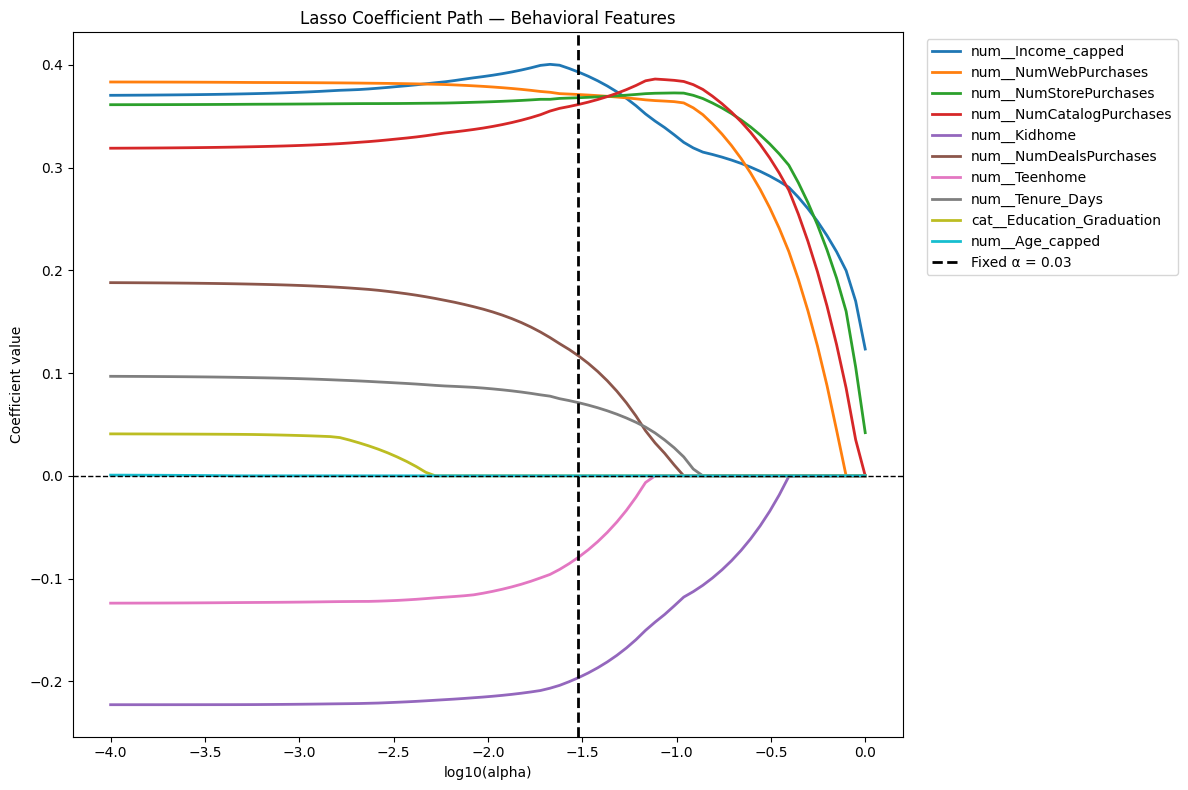

In [586]:
# ============================================================
# Lasso Coefficient Path — Variant A (Behavioral)
# ============================================================

# Prepare design matrix (after preprocessing)
X_train_prepared = preprocessor.fit_transform(X_train_m5)
feature_names = preprocessor.get_feature_names_out()

# Define alpha grid
alphas = np.logspace(-4, 0, 80)

coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=50000)
    lasso.fit(X_train_prepared, y_train_m5)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# Fixed alpha (from Model 5)
alpha_fixed = 0.03
idx_fixed = np.argmin(np.abs(alphas - alpha_fixed))
coef_at_fixed = coefs[idx_fixed]

# Select top 10 features by |coef| at fixed alpha
top_idx_sorted = np.argsort(np.abs(coef_at_fixed))[-10:][::-1]

# Plot
plt.figure(figsize=(12, 8))

for i in top_idx_sorted:
    plt.plot(
        np.log10(alphas),
        coefs[:, i],
        linewidth=2,
        label=feature_names[i]
    )

plt.axvline(
    np.log10(alpha_fixed),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Fixed α = {alpha_fixed}"
)

plt.axhline(y=0, color="black", linestyle="--", linewidth=1)

y_min = coefs[:, top_idx_sorted].min()
y_max = coefs[:, top_idx_sorted].max()
pad = 0.05 * (y_max - y_min)
plt.ylim(y_min - pad, y_max + pad)

plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Path — Behavioral Features")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### 🔹 Variant B — Profile-only feature set

In [587]:
# ============================================================
# Model 5 — Lasso Regression (Fixed Alpha)
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m5 = X_train[num_cols + cat_cols]
X_test_m5  = X_test[num_cols + cat_cols]

y_train_m5 = y_train_log
y_test_m5  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

alpha_fixed = 0.03   # chosen based on LassoCV results

lasso_fixed = Lasso(
    alpha=alpha_fixed,
    max_iter=50000,
    random_state=42
)

pipe_lasso_fixed = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso_fixed)
    ]
)

# ----------------------------
# Fit model
# ----------------------------
pipe_lasso_fixed.fit(X_train_m5, y_train_m5)

# ----------------------------
# Predictions & metrics
# ----------------------------
y_train_pred = pipe_lasso_fixed.predict(X_train_m5)
y_test_pred  = pipe_lasso_fixed.predict(X_test_m5)

r2_train = r2_score(y_train_m5, y_train_pred)
r2_test  = r2_score(y_test_m5, y_test_pred)
mse_train = mean_squared_error(y_train_m5, y_train_pred)
mse_test  = mean_squared_error(y_test_m5, y_test_pred)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso_fixed, X_train_m5, y_train_m5, cv=cv, scoring="r2"
).mean()

# ----------------------------
# Selected features
# ----------------------------
feature_names = pipe_lasso_fixed.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_fixed.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if c != 0]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
n_selected = len(selected_sorted)

# ----------------------------
# Logging
# ----------------------------
log_profile_model(
    name="Model 5 — LassoCV (Fixed Alpha)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=n_selected,
    notes="Profile-only features, fixed alpha from LassoCV"
)

# ----------------------------
# Report
# ----------------------------
print("Model 5 — LassoCV (Fixed Alpha)")
print(f"Alpha fixed: {alpha_fixed}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"\nSelected features: {n_selected}")

for name, coef in selected_sorted:
    print(f"  {name:45s}  coef = {coef:+.4f}")


Model 5 — LassoCV (Fixed Alpha)
Alpha fixed: 0.03
R² test : 0.671
R² train: 0.666
R² CV   : 0.665

Selected features: 3
  num__Income_capped                             coef = +0.9035
  num__Kidhome                                   coef = -0.4177
  num__Teenhome                                  coef = -0.0166


##### 🔹 Coefficient Path — Variant B (Profile-only)

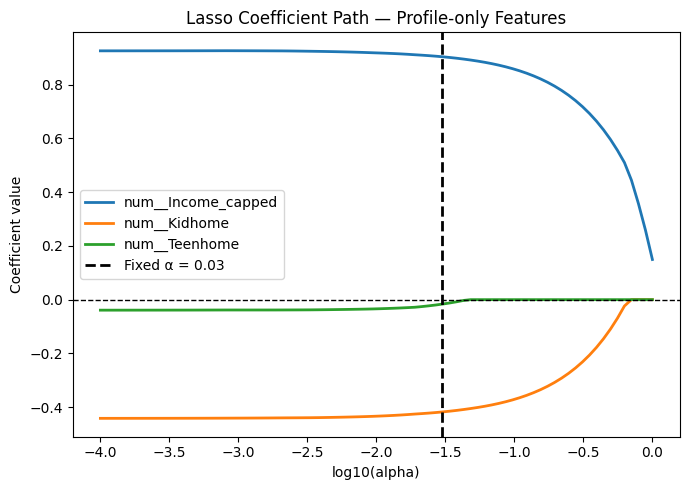

In [588]:
# ============================================================
# Lasso Coefficient Path — Variant B (Profile-only)
# ============================================================

# Prepare design matrix (after preprocessing)
X_train_prepared = preprocessor.fit_transform(X_train_m5)
feature_names = preprocessor.get_feature_names_out()

# Define alpha grid
alphas = np.logspace(-4, 0, 80)

coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=50000)
    lasso.fit(X_train_prepared, y_train_m5)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

# Fixed alpha (from Model 5)
alpha_fixed = 0.03
idx_fixed = np.argmin(np.abs(alphas - alpha_fixed))
coef_at_fixed = coefs[idx_fixed]

# Select all non-zero features (usually very few here)
top_idx_sorted = np.argsort(np.abs(coef_at_fixed))[::-1]

# Plot
plt.figure(figsize=(7, 5))

for i in top_idx_sorted:
    if coef_at_fixed[i] != 0:
        plt.plot(
            np.log10(alphas),
            coefs[:, i],
            linewidth=2,
            label=feature_names[i]
        )

plt.axvline(
    np.log10(alpha_fixed),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Fixed α = {alpha_fixed}"
)

plt.axhline(y=0, color="black", linestyle="--", linewidth=1)

plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Path — Profile-only Features")
plt.legend()
plt.tight_layout()
plt.show()


### Model 6 — Linear Regression (Lasso-selected Features)

This model retrains a linear regression using only the features selected
by Lasso with a fixed regularization strength (α = 0.03).

By removing regularization in the final step, this model evaluates whether
Lasso-selected features can achieve strong performance while improving
interpretability and coefficient stability.

The model is evaluated under two scenarios:
- Behavioral feature set (upper-bound benchmark)
- Customer profile feature set (realistic predictive scenario)


#### 🔹 Variant A — Profile + Behavioral feature set

In [589]:
# ============================================================
# Model 6 — Linear Regression (Lasso-selected features)
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "NumCatalogPurchases",
    "Income_capped",
    "NumWebPurchases",
    "NumStorePurchases",
    "Kidhome",
    "NumDealsPurchases",
    "Teenhome",
    "Tenure_Days"
]

X_train_m6 = X_train[num_cols]
X_test_m6  = X_test[num_cols]

y_train_m6 = y_train_log
y_test_m6  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols)
    ]
)

pipe_lr_lasso = Pipeline(
    [
        ("pre", preprocessor),
        ("linreg", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr_lasso, X_train_m6, y_train_m6, cv=cv, scoring="r2"
).mean()

pipe_lr_lasso.fit(X_train_m6, y_train_m6)

y_train_pred = pipe_lr_lasso.predict(X_train_m6)
y_test_pred  = pipe_lr_lasso.predict(X_test_m6)

r2_train = r2_score(y_train_m6, y_train_pred)
r2_test  = r2_score(y_test_m6, y_test_pred)
mse_train = mean_squared_error(y_train_m6, y_train_pred)
mse_test  = mean_squared_error(y_test_m6, y_test_pred)

coefs = pipe_lr_lasso.named_steps["linreg"].coef_
coef_table = sorted(
    zip(num_cols, coefs),
    key=lambda x: abs(x[1]),
    reverse=True
)

log_behavioral_model(
    name="Model 6 — Linear Regression (Lasso-selected)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=len(num_cols),
    notes="Linear regression on Lasso-selected behavioral features (α=0.03)"
)

print("Model 6 — Linear Regression (Lasso-selected)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print("\nSelected coefficients (sorted by |coef|):")
for name, c in coef_table:
    print(f"{name:30s}  coef = {c:+.4f}")


Model 6 — Linear Regression (Lasso-selected)
R² test : 0.882
R² train: 0.870
R² CV   : 0.864

Selected coefficients (sorted by |coef|):
Income_capped                   coef = +0.4251
NumWebPurchases                 coef = +0.3752
NumStorePurchases               coef = +0.3649
NumCatalogPurchases             coef = +0.3432
Kidhome                         coef = -0.2328
NumDealsPurchases               coef = +0.1743
Teenhome                        coef = -0.1367
Tenure_Days                     coef = +0.0899


#### 🔹 Variant B — Profile-only feature set

In [590]:
# ============================================================
# Model 6 — Linear Regression (Lasso-selected features)
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Kidhome",
    "Teenhome",
]

X_train_m6 = X_train[num_cols]
X_test_m6  = X_test[num_cols]

y_train_m6 = y_train_log
y_test_m6  = y_test_log

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols)
    ]
)

pipe_lr_lasso = Pipeline(
    [
        ("pre", preprocessor),
        ("linreg", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lr_lasso, X_train_m6, y_train_m6, cv=cv, scoring="r2"
).mean()

pipe_lr_lasso.fit(X_train_m6, y_train_m6)

y_train_pred = pipe_lr_lasso.predict(X_train_m6)
y_test_pred  = pipe_lr_lasso.predict(X_test_m6)

r2_train = r2_score(y_train_m6, y_train_pred)
r2_test  = r2_score(y_test_m6, y_test_pred)
mse_train = mean_squared_error(y_train_m6, y_train_pred)
mse_test  = mean_squared_error(y_test_m6, y_test_pred)

coefs = pipe_lr_lasso.named_steps["linreg"].coef_
coef_table = sorted(
    zip(num_cols, coefs),
    key=lambda x: abs(x[1]),
    reverse=True
)

log_profile_model(
    name="Model 6 — Linear Regression (Lasso-selected)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=len(num_cols),
    notes="Linear regression on Lasso-selected profile features (α=0.03)"
)

print("Model 6 — Linear Regression (Lasso-selected)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print("\nSelected coefficients (sorted by |coef|):")
for name, c in coef_table:
    print(f"{name:30s}  coef = {c:+.4f}")


Model 6 — Linear Regression (Lasso-selected)
R² test : 0.672
R² train: 0.667
R² CV   : 0.666

Selected coefficients (sorted by |coef|):
Income_capped                   coef = +0.9238
Kidhome                         coef = -0.4390
Teenhome                        coef = -0.0485


## 4. Polynomial Regression Models

Linear models assume additive and linear relationships between features and the target.
In this section, polynomial regression models are introduced to explicitly capture
second-order interactions and non-linear effects between predictors.

Polynomial features increase model flexibility by allowing interactions such as:
- Income × Tenure
- Age²
- Income × Age

However, this increased flexibility also raises the risk of overfitting.
Therefore, polynomial models are evaluated both in unregularized and regularized forms
(Ridge and Lasso) to control model complexity.

All polynomial models use degree = 2 and follow the same leakage-safe preprocessing
and evaluation framework as previous models.


### Model 7 — Polynomial Linear Regression (degree = 2)

#### 🔹 Variant A — Profile + Behavioral feature set

In [591]:
# ============================================================
# Model 7 — Polynomial Linear Regression (degree = 2)
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m7 = X_train[num_cols + cat_cols]
X_test_m7  = X_test[num_cols + cat_cols]

y_train_m7 = y_train_log
y_test_m7  = y_test_log

# ------------------------------------------------------------
# Preprocessing: Polynomial only on numeric features
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("linreg", LinearRegression())
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_poly, X_train_m7, y_train_m7, cv=cv, scoring="r2"
).mean()

pipe_poly.fit(X_train_m7, y_train_m7)

y_train_pred = pipe_poly.predict(X_train_m7)
y_test_pred  = pipe_poly.predict(X_test_m7)

r2_train = r2_score(y_train_m7, y_train_pred)
r2_test  = r2_score(y_test_m7, y_test_pred)
mse_train = mean_squared_error(y_train_m7, y_train_pred)
mse_test  = mean_squared_error(y_test_m7, y_test_pred)

pre = pipe_poly.named_steps["pre"]
n_num_after = pre.named_transformers_["num"].named_steps["poly"].n_output_features_
n_cat_after = len(pre.named_transformers_["cat"].get_feature_names_out(cat_cols))
feature_count = n_num_after + n_cat_after

log_behavioral_model(
    name="Model 7 — Polynomial Linear Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial degree=2 on behavioral features"
)

print("Model 7 — Polynomial Linear Regression")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric before:            {len(num_cols)}")
print(f"  Categorical before:        {len(cat_cols)}")
print(f"  Numeric after poly(deg=2): {n_num_after}")
print(f"  Categorical after OHE:     {n_cat_after}")
print(f"  TOTAL after preprocessing: {feature_count}")


Model 7 — Polynomial Linear Regression
R² test : 0.958
R² train: 0.961
R² CV   : 0.933

Feature counts:
  Numeric before:            11
  Categorical before:        9
  Numeric after poly(deg=2): 77
  Categorical after OHE:     16
  TOTAL after preprocessing: 93


#### Diagnostic plots — Model 7 (Variant A)

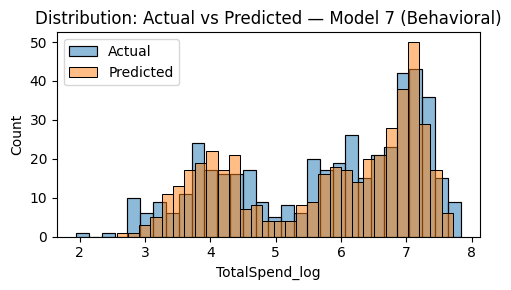

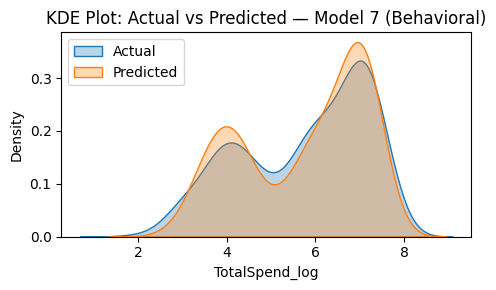

In [592]:
# ==========================================
# Diagnostic plots — Model 7 (Variant A)
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram: Actual vs Predicted
plt.figure(figsize=(5, 3))
sns.histplot(y_test_m7, label="Actual", bins=30, alpha=0.5)
sns.histplot(y_test_pred, label="Predicted", bins=30, alpha=0.5)
plt.title("Distribution: Actual vs Predicted — Model 7 (Behavioral)")
plt.xlabel("TotalSpend_log")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# KDE plot: Actual vs Predicted
plt.figure(figsize=(5, 3))
sns.kdeplot(y_test_m7, label="Actual", fill=True, alpha=0.3)
sns.kdeplot(y_test_pred, label="Predicted", fill=True, alpha=0.3)
plt.title("KDE Plot: Actual vs Predicted — Model 7 (Behavioral)")
plt.xlabel("TotalSpend_log")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


#### 🔹 Variant B — Profile-only feature set

In [593]:
# ============================================================
# Model 7 — Polynomial Linear Regression (degree = 2)
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome",
]

cat_cols = [
    "Education",
    "Marital_Status",
]

X_train_m7 = X_train[num_cols + cat_cols]
X_test_m7  = X_test[num_cols + cat_cols]

y_train_m7 = y_train_log
y_test_m7  = y_test_log

# ------------------------------------------------------------
# Preprocessing
#   - Polynomial only on numeric
#   - OHE on categorical
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

pipe_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("linreg", LinearRegression())
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_poly, X_train_m7, y_train_m7, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit & evaluate
# ------------------------------------------------------------
pipe_poly.fit(X_train_m7, y_train_m7)

y_train_pred = pipe_poly.predict(X_train_m7)
y_test_pred  = pipe_poly.predict(X_test_m7)

r2_train = r2_score(y_train_m7, y_train_pred)
r2_test  = r2_score(y_test_m7, y_test_pred)
mse_train = mean_squared_error(y_train_m7, y_train_pred)
mse_test  = mean_squared_error(y_test_m7, y_test_pred)

# ------------------------------------------------------------
# Feature count diagnostics
# ------------------------------------------------------------
pre = pipe_poly.named_steps["pre"]

# numeric after polynomial expansion
n_num_after = (
    pre
    .named_transformers_["num"]
    .named_steps["poly"]
    .n_output_features_
)

# categorical after OHE
n_cat_after = len(
    pre
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Log results
# ------------------------------------------------------------
log_profile_model(
    name="Model 7 — Polynomial Linear Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial degree=2 on profile-only features (numeric + categorical)"
)

# ------------------------------------------------------------
# Report
# ------------------------------------------------------------
print("Model 7 — Polynomial Linear Regression")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric before:            {len(num_cols)}")
print(f"  Categorical before:        {len(cat_cols)}")
print(f"  Numeric after poly(deg=2): {n_num_after}")
print(f"  Categorical after OHE:     {n_cat_after}")
print(f"  TOTAL after preprocessing: {feature_count}")


Model 7 — Polynomial Linear Regression
R² test : 0.728
R² train: 0.725
R² CV   : 0.712

Feature counts:
  Numeric before:            4
  Categorical before:        2
  Numeric after poly(deg=2): 14
  Categorical after OHE:     9
  TOTAL after preprocessing: 23


#### Diagnostic plots — Model 7 (Variant B)

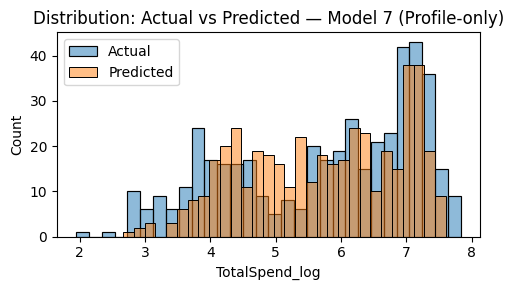

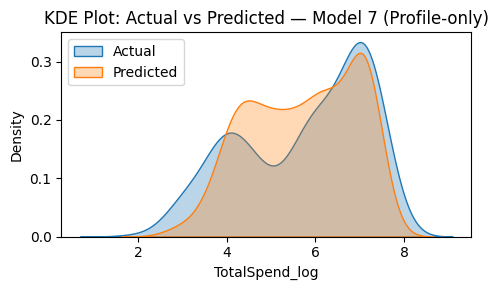

In [594]:
# ==========================================
# Diagnostic plots — Model 7 (Variant B)
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram: Actual vs Predicted
plt.figure(figsize=(5, 3))
sns.histplot(y_test_m7, label="Actual", bins=30, alpha=0.5)
sns.histplot(y_test_pred, label="Predicted", bins=30, alpha=0.5)
plt.title("Distribution: Actual vs Predicted — Model 7 (Profile-only)")
plt.xlabel("TotalSpend_log")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# KDE plot: Actual vs Predicted
plt.figure(figsize=(5, 3))
sns.kdeplot(y_test_m7, label="Actual", fill=True, alpha=0.3)
sns.kdeplot(y_test_pred, label="Predicted", fill=True, alpha=0.3)
plt.title("KDE Plot: Actual vs Predicted — Model 7 (Profile-only)")
plt.xlabel("TotalSpend_log")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


### Model 8 — Polynomial Ridge Regression (degree = 2)

#### 🔹 Variant A — Profile + Behavioral feature set

In [595]:
# ============================================================
# Model 8 — Polynomial Ridge Regression (degree = 2)
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m8 = X_train[num_cols + cat_cols]
X_test_m8  = X_test[num_cols + cat_cols]

y_train_m8 = y_train_log
y_test_m8  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# ------------------------------------------------------------
# RidgeCV
# ------------------------------------------------------------
alphas = np.logspace(-2, 2, 50)
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = RidgeCV(
    alphas=alphas,
    cv=cv5,
    scoring="r2"
)

pipe_ridge_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("ridge", ridge)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
r2_cv = cross_val_score(
    pipe_ridge_poly, X_train_m8, y_train_m8, cv=cv5, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit & evaluate
# ------------------------------------------------------------
pipe_ridge_poly.fit(X_train_m8, y_train_m8)

y_train_pred = pipe_ridge_poly.predict(X_train_m8)
y_test_pred  = pipe_ridge_poly.predict(X_test_m8)

r2_train = r2_score(y_train_m8, y_train_pred)
r2_test  = r2_score(y_test_m8, y_test_pred)
mse_train = mean_squared_error(y_train_m8, y_train_pred)
mse_test  = mean_squared_error(y_test_m8, y_test_pred)

# ------------------------------------------------------------
# Feature count diagnostics
# ------------------------------------------------------------
pre = pipe_ridge_poly.named_steps["pre"]

n_num_after = (
    pre
    .named_transformers_["num"]
    .named_steps["poly"]
    .n_output_features_
)

n_cat_after = len(
    pre
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 8 — Polynomial Ridge Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial deg=2 + RidgeCV on behavioral features"
)

print("Model 8 — Polynomial Ridge Regression")
print(f"Best α: {pipe_ridge_poly.named_steps['ridge'].alpha_:.4f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print("\nFeature counts:")
print(f"  Numeric before:            {len(num_cols)}")
print(f"  Categorical before:        {len(cat_cols)}")
print(f"  Numeric after poly(deg=2): {n_num_after}")
print(f"  Categorical after OHE:     {n_cat_after}")
print(f"  TOTAL after preprocessing: {feature_count}")  


Model 8 — Polynomial Ridge Regression
Best α: 7.1969
R² test : 0.956
R² train: 0.960
R² CV   : 0.934

Feature counts:
  Numeric before:            11
  Categorical before:        9
  Numeric after poly(deg=2): 77
  Categorical after OHE:     16
  TOTAL after preprocessing: 93


#### 🔹 Variant B — Profile-only feature set

In [596]:
# ============================================================
# Model 8 — Polynomial Ridge Regression (degree = 2)
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m8 = X_train[num_cols + cat_cols]
X_test_m8  = X_test[num_cols + cat_cols]

y_train_m8 = y_train_log
y_test_m8  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# ------------------------------------------------------------
# RidgeCV
# ------------------------------------------------------------
alphas = np.logspace(-2, 2, 50)
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = RidgeCV(
    alphas=alphas,
    cv=cv5,
    scoring="r2"
)

pipe_ridge_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("ridge", ridge)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
r2_cv = cross_val_score(
    pipe_ridge_poly, X_train_m8, y_train_m8, cv=cv5, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit & evaluate
# ------------------------------------------------------------
pipe_ridge_poly.fit(X_train_m8, y_train_m8)

y_train_pred = pipe_ridge_poly.predict(X_train_m8)
y_test_pred  = pipe_ridge_poly.predict(X_test_m8)

r2_train = r2_score(y_train_m8, y_train_pred)
r2_test  = r2_score(y_test_m8, y_test_pred)
mse_train = mean_squared_error(y_train_m8, y_train_pred)
mse_test  = mean_squared_error(y_test_m8, y_test_pred)

# ------------------------------------------------------------
# Feature count diagnostics
# ------------------------------------------------------------
pre = pipe_ridge_poly.named_steps["pre"]

n_num_after = (
    pre
    .named_transformers_["num"]
    .named_steps["poly"]
    .n_output_features_
)

n_cat_after = len(
    pre
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_profile_model(
    name="Model 8 — Polynomial Ridge Regression",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial deg=2 + RidgeCV on profile-only features"
)

print("Model 8 — Polynomial Ridge Regression")
print(f"Best α: {pipe_ridge_poly.named_steps['ridge'].alpha_:.4f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
# ============================================================
print("\nFeature counts:")
print(f"  Numeric before:            {len(num_cols)}")
print(f"  Categorical before:        {len(cat_cols)}")
print(f"  Numeric after poly(deg=2): {n_num_after}")
print(f"  Categorical after OHE:     {n_cat_after}")
print(f"  TOTAL after preprocessing: {feature_count}")  

Model 8 — Polynomial Ridge Regression
Best α: 3.3932
R² test : 0.727
R² train: 0.724
R² CV   : 0.713

Feature counts:
  Numeric before:            4
  Categorical before:        2
  Numeric after poly(deg=2): 14
  Categorical after OHE:     9
  TOTAL after preprocessing: 23


### Model 9 — Polynomial LassoCV (degree = 2)

#### 🔹 Variant A — Profile + Behavioral feature set

In [597]:
# ============================================================
# Model 9 — Polynomial LassoCV (degree = 2)
# Variant A: Behavioral feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m9 = X_train[num_cols + cat_cols]
X_test_m9  = X_test[num_cols + cat_cols]

y_train_m9 = y_train_log
y_test_m9  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# ------------------------------------------------------------
# LassoCV
# ------------------------------------------------------------
alphas = np.logspace(-4, 1, 40)
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

lasso_cv = LassoCV(
    alphas=alphas,
    cv=cv5,
    max_iter=100000,
    random_state=42
)

pipe_lasso_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso_cv)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
r2_cv = cross_val_score(
    pipe_lasso_poly, X_train_m9, y_train_m9, cv=cv5, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit & evaluate
# ------------------------------------------------------------
pipe_lasso_poly.fit(X_train_m9, y_train_m9)

y_train_pred = pipe_lasso_poly.predict(X_train_m9)
y_test_pred  = pipe_lasso_poly.predict(X_test_m9)

r2_train = r2_score(y_train_m9, y_train_pred)
r2_test  = r2_score(y_test_m9, y_test_pred)
mse_train = mean_squared_error(y_train_m9, y_train_pred)
mse_test  = mean_squared_error(y_test_m9, y_test_pred)

# ------------------------------------------------------------
# Selected features
# ------------------------------------------------------------
feature_names = pipe_lasso_poly.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_poly.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if abs(c) > 1e-8]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
feature_count = len(selected)

# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 9 — Polynomial LassoCV",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial deg=2 + LassoCV on behavioral features"
)

print("Model 9 — Polynomial LassoCV")
print(f"Best α: {pipe_lasso_poly.named_steps['lasso'].alpha_:.6f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nTotal features after preprocessing: {len(feature_names)}")
selected_count = len([c for c in coefs if abs(c) > 1e-8])   
print(f"Selected (non-zero) features: {selected_count} / {len(feature_names)}")
print(f"\nSelected features: {feature_count }")
for name, coef in selected_sorted[:15]:
    print(f"{name:55s}  coef = {coef:+.4f}")



Model 9 — Polynomial LassoCV
Best α: 0.003455
R² test : 0.953
R² train: 0.956
R² CV   : 0.940

Total features after preprocessing: 93
Selected (non-zero) features: 51 / 93

Selected features: 51
num__NumCatalogPurchases                                 coef = +1.1880
num__NumWebPurchases                                     coef = +1.0120
num__NumStorePurchases                                   coef = +0.6404
num__Income_capped                                       coef = +0.5316
num__NumCatalogPurchases NumStorePurchases               coef = -0.4314
num__NumCatalogPurchases^2                               coef = -0.3922
num__NumWebPurchases^2                                   coef = -0.3804
num__NumWebPurchases NumStorePurchases                   coef = -0.3718
num__Income_capped^2                                     coef = -0.3037
num__NumWebVisitsMonth^2                                 coef = +0.2989
num__NumWebPurchases NumCatalogPurchases                 coef = -0.2860
num__NumWebVi

#### 🔹 Variant B — Profile-only feature set

In [598]:
# ============================================================
# Model 9 — Polynomial LassoCV (degree = 2)
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m9 = X_train[num_cols + cat_cols]
X_test_m9  = X_test[num_cols + cat_cols]

y_train_m9 = y_train_log
y_test_m9  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
num_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_poly, num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# ------------------------------------------------------------
# LassoCV
# ------------------------------------------------------------
alphas = np.logspace(-4, 1, 40)
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

lasso_cv = LassoCV(
    alphas=alphas,
    cv=cv5,
    max_iter=100000,
    random_state=42
)

pipe_lasso_poly = Pipeline(
    [
        ("pre", preprocessor),
        ("lasso", lasso_cv)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
r2_cv = cross_val_score(
    pipe_lasso_poly, X_train_m9, y_train_m9, cv=cv5, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit & evaluate
# ------------------------------------------------------------
pipe_lasso_poly.fit(X_train_m9, y_train_m9)

y_train_pred = pipe_lasso_poly.predict(X_train_m9)
y_test_pred  = pipe_lasso_poly.predict(X_test_m9)

r2_train = r2_score(y_train_m9, y_train_pred)
r2_test  = r2_score(y_test_m9, y_test_pred)
mse_train = mean_squared_error(y_train_m9, y_train_pred)
mse_test  = mean_squared_error(y_test_m9, y_test_pred)

# ------------------------------------------------------------
# Selected features
# ------------------------------------------------------------
feature_names = pipe_lasso_poly.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_poly.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if abs(c) > 1e-8]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
feature_count = len(selected)

# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_profile_model(
    name="Model 9 — Polynomial LassoCV",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Polynomial deg=2 + LassoCV on profile-only features"
)

print("Model 9 — Polynomial LassoCV")
print(f"Best α: {pipe_lasso_poly.named_steps['lasso'].alpha_:.6f}")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nTotal features after preprocessing: {len(feature_names)}")
selected_count = len([c for c in coefs if abs(c) > 1e-8])   
print(f"Selected (non-zero) features: {selected_count} / {len(feature_names)}")
print(f"\nSelected features: {feature_count}")
for name, coef in selected_sorted:
    print(f"{name:55s}  coef = {coef:+.4f}")


Model 9 — Polynomial LassoCV
Best α: 0.002572
R² test : 0.729
R² train: 0.723
R² CV   : 0.713

Total features after preprocessing: 23
Selected (non-zero) features: 14 / 23

Selected features: 14
num__Income_capped                                       coef = +1.9493
num__Income_capped^2                                     coef = -1.0565
num__Kidhome                                             coef = -0.3502
num__Teenhome                                            coef = -0.3271
num__Income_capped Teenhome                              coef = +0.1756
num__Kidhome^2                                           coef = +0.1308
num__Income_capped Kidhome                               coef = -0.0853
cat__Education_Basic                                     coef = +0.0811
num__Age_capped Kidhome                                  coef = -0.0806
num__Teenhome^2                                          coef = +0.0646
cat__Education_PhD                                       coef = -0.0582
num__Age_capp

### Model 10 — Polynomial Lasso (degree = 2, fixed α)

#### 🔹 Variant A — Profile + Behavioral feature set

In [599]:
alpha_fixed = 0.016

num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m10_A = X_train[num_cols + cat_cols]
X_test_m10_A  = X_test[num_cols + cat_cols]

y_train_m10 = y_train_log
y_test_m10  = y_test_log



num_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_poly, num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

lasso_fixed = Lasso(
    alpha=alpha_fixed,
    max_iter=100_000,
    random_state=42
)

pipe_lasso_poly_fixed_behavioral = Pipeline([
    ("pre", preprocessor),
    ("lasso", lasso_fixed)
])

pipe_lasso_poly_fixed_behavioral.fit(X_train_m10_A, y_train_m10)

y_train_pred = pipe_lasso_poly_fixed_behavioral.predict(X_train_m10_A)
y_test_pred  = pipe_lasso_poly_fixed_behavioral.predict(X_test_m10_A)

r2_train = r2_score(y_train_m10, y_train_pred)
r2_test  = r2_score(y_test_m10, y_test_pred)
mse_train = mean_squared_error(y_train_m10, y_train_pred)
mse_test  = mean_squared_error(y_test_m10, y_test_pred)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso_poly_fixed_behavioral, X_train_m10_A, y_train_m10, cv=cv, scoring="r2"
).mean()

feature_names = pipe_lasso_poly_fixed_behavioral.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_poly_fixed_behavioral.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if abs(c) > 1e-8]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
selected_count = len(selected)

log_behavioral_model(
    name="Model 10 — Polynomial Lasso (fixed α)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=selected_count,
    notes=f"deg=2, fixed α={alpha_fixed}"
)

print("Model 10 — Polynomial Lasso (fixed α)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nSelected features: {selected_count} / {len(feature_names)}")
for name, coef in selected_sorted[:20]:
    print(f"{name:55s}  coef = {coef:+.4f}")


Model 10 — Polynomial Lasso (fixed α)
R² test : 0.933
R² train: 0.929
R² CV   : 0.922

Selected features: 22 / 93
num__NumCatalogPurchases                                 coef = +0.9317
num__NumWebPurchases                                     coef = +0.7546
num__NumStorePurchases                                   coef = +0.5136
num__NumCatalogPurchases^2                               coef = -0.3353
num__Income_capped                                       coef = +0.3219
num__NumWebPurchases^2                                   coef = -0.2657
num__Kidhome                                             coef = -0.2413
num__NumWebPurchases NumStorePurchases                   coef = -0.2242
num__NumCatalogPurchases NumStorePurchases               coef = -0.2167
num__NumWebPurchases NumCatalogPurchases                 coef = -0.1613
num__Teenhome                                            coef = -0.0708
num__Kidhome NumCatalogPurchases                         coef = +0.0625
num__Kidhome NumWebPur

In [600]:
pipe_lasso_poly_fixed_behavioral

,steps,"[('pre', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [601]:
pipe_lasso_poly_fixed_behavioral.named_steps.keys()

dict_keys(['pre', 'lasso'])

#### 🔹 Variant B — Profile-only feature set

In [602]:
alpha_fixed = 0.020

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m10_B = X_train[num_cols + cat_cols]
X_test_m10_B  = X_test[num_cols + cat_cols]

y_train_m10 = y_train_log
y_test_m10  = y_test_log

num_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_poly, num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

lasso_fixed = Lasso(
    alpha=alpha_fixed,
    max_iter=100_000,
    random_state=42
)

pipe_lasso_poly_fixed_profile = Pipeline([
    ("pre", preprocessor),
    ("lasso", lasso_fixed)
])

pipe_lasso_poly_fixed_profile.fit(X_train_m10_B, y_train_m10)

y_train_pred = pipe_lasso_poly_fixed_profile.predict(X_train_m10_B)
y_test_pred  = pipe_lasso_poly_fixed_profile.predict(X_test_m10_B)

r2_train = r2_score(y_train_m10, y_train_pred)
r2_test  = r2_score(y_test_m10, y_test_pred)
mse_train = mean_squared_error(y_train_m10, y_train_pred)
mse_test  = mean_squared_error(y_test_m10, y_test_pred)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_lasso_poly_fixed_profile, X_train_m10_B, y_train_m10, cv=cv, scoring="r2"
).mean()

feature_names = pipe_lasso_poly_fixed_profile.named_steps["pre"].get_feature_names_out()
coefs = pipe_lasso_poly_fixed_profile.named_steps["lasso"].coef_

selected = [(n, c) for n, c in zip(feature_names, coefs) if abs(c) > 1e-8]
selected_sorted = sorted(selected, key=lambda x: abs(x[1]), reverse=True)
selected_count = len(selected)

log_profile_model(
    name="Model 10 — Polynomial Lasso (fixed α)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=selected_count,
    notes=f"deg=2, fixed α={alpha_fixed}"
)

print("Model 10 — Polynomial Lasso (fixed α)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nSelected features: {selected_count} / {len(feature_names)}")
for name, coef in selected_sorted:
    print(f"{name:55s}  coef = {coef:+.4f}")


Model 10 — Polynomial Lasso (fixed α)
R² test : 0.714
R² train: 0.709
R² CV   : 0.703

Selected features: 7 / 23
num__Income_capped                                       coef = +1.5661
num__Income_capped^2                                     coef = -0.6535
num__Kidhome                                             coef = -0.2147
num__Age_capped Kidhome                                  coef = -0.1434
num__Teenhome                                            coef = -0.0424
num__Kidhome Teenhome                                    coef = -0.0392
num__Income_capped Kidhome                               coef = -0.0150


### Model 11 — Linear Regression (on Polynomial Lasso–selected features)

#### 🔹 Variant A — Profile + Behavioral feature set

In [603]:
# ------------------------------------------------------------
# 1) Polynomial feature space (from Model 10A)
# ------------------------------------------------------------
X_train_poly = pipe_lasso_poly_fixed_behavioral.named_steps["pre"].transform(X_train_m10_A)
X_test_poly  = pipe_lasso_poly_fixed_behavioral.named_steps["pre"].transform(X_test_m10_A)

feature_names_poly = (
    pipe_lasso_poly_fixed_behavioral
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# 2) Select polynomial features kept by Lasso
# ------------------------------------------------------------
coefs = pipe_lasso_poly_fixed_behavioral.named_steps["lasso"].coef_
selected_idx = [i for i, c in enumerate(coefs) if abs(c) > 1e-8]

X_train_sel = X_train_poly[:, selected_idx]
X_test_sel  = X_test_poly[:, selected_idx]

selected_feature_names = feature_names_poly[selected_idx]
feature_count = len(selected_idx)

# ------------------------------------------------------------
# 3) Linear Regression
# ------------------------------------------------------------
linreg = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    linreg, X_train_sel, y_train_log, cv=cv, scoring="r2"
).mean()

linreg.fit(X_train_sel, y_train_log)

# ------------------------------------------------------------
# 4) Metrics
# ------------------------------------------------------------
y_train_pred = linreg.predict(X_train_sel)
y_test_pred  = linreg.predict(X_test_sel)

r2_train = r2_score(y_train_log, y_train_pred)
r2_test  = r2_score(y_test_log, y_test_pred)
mse_train = mean_squared_error(y_train_log, y_train_pred)
mse_test  = mean_squared_error(y_test_log, y_test_pred)

# ------------------------------------------------------------
# 5) Coefficients
# ------------------------------------------------------------
coef_table = sorted(
    zip(selected_feature_names, linreg.coef_),
    key=lambda x: abs(x[1]),
    reverse=True
)

# ------------------------------------------------------------
# 6) Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 11 — Linear Regression (Poly Lasso-selected)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Linear regression on polynomial features selected by Lasso (Model 10A)"
)

print("Model 11 — Linear Regression (Poly Lasso-selected)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nFinal feature count: {feature_count}")
print("\nTop coefficients:")
for name, coef in coef_table[:20]:
    print(f"{name:60s}  coef = {coef:+.4f}")


Model 11 — Linear Regression (Poly Lasso-selected)
R² test : 0.948
R² train: 0.949
R² CV   : 0.944

Final feature count: 22

Top coefficients:
num__NumCatalogPurchases                                      coef = +1.4773
num__NumWebPurchases                                          coef = +1.0074
num__NumStorePurchases                                        coef = +0.8217
num__Income_capped                                            coef = +0.6470
num__NumCatalogPurchases NumStorePurchases                    coef = -0.5886
num__NumCatalogPurchases^2                                    coef = -0.5187
num__NumWebPurchases NumStorePurchases                        coef = -0.5001
num__NumWebPurchases^2                                        coef = -0.3611
num__Income_capped^2                                          coef = -0.3447
num__NumWebPurchases NumCatalogPurchases                      coef = -0.2625
num__Kidhome                                                  coef = -0.1763
num__NumWe

#### 🔹 Variant B — Profile-only feature set

In [604]:
# ------------------------------------------------------------
# 1) Polynomial feature space (from Model 10B)
# ------------------------------------------------------------
X_train_poly = pipe_lasso_poly_fixed_profile.named_steps["pre"].transform(X_train_m10_B)
X_test_poly  = pipe_lasso_poly_fixed_profile.named_steps["pre"].transform(X_test_m10_B)

feature_names_poly = (
    pipe_lasso_poly_fixed_profile
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# 2) Select polynomial features kept by Lasso
# ------------------------------------------------------------
coefs = pipe_lasso_poly_fixed_profile.named_steps["lasso"].coef_
selected_idx = [i for i, c in enumerate(coefs) if abs(c) > 1e-8]

X_train_sel = X_train_poly[:, selected_idx]
X_test_sel  = X_test_poly[:, selected_idx]

selected_feature_names = feature_names_poly[selected_idx]
feature_count = len(selected_idx)

# ------------------------------------------------------------
# 3) Linear Regression
# ------------------------------------------------------------
linreg = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    linreg, X_train_sel, y_train_log, cv=cv, scoring="r2"
).mean()

linreg.fit(X_train_sel, y_train_log)

# ------------------------------------------------------------
# 4) Metrics
# ------------------------------------------------------------
y_train_pred = linreg.predict(X_train_sel)
y_test_pred  = linreg.predict(X_test_sel)

r2_train = r2_score(y_train_log, y_train_pred)
r2_test  = r2_score(y_test_log, y_test_pred)
mse_train = mean_squared_error(y_train_log, y_train_pred)
mse_test  = mean_squared_error(y_test_log, y_test_pred)

# ------------------------------------------------------------
# 5) Coefficients
# ------------------------------------------------------------
coef_table = sorted(
    zip(selected_feature_names, linreg.coef_),
    key=lambda x: abs(x[1]),
    reverse=True
)

# ------------------------------------------------------------
# 6) Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 11 — Linear Regression (Poly Lasso-selected)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Linear regression on polynomial features selected by Lasso (Model 10B)"
)

print("Model 11 — Linear Regression (Poly Lasso-selected)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")

print(f"\nFinal feature count: {feature_count}")
print("\nTop coefficients:")
for name, coef in coef_table[:20]:
    print(f"{name:60s}  coef = {coef:+.4f}")


Model 11 — Linear Regression (Poly Lasso-selected)
R² test : 0.726
R² train: 0.719
R² CV   : 0.714

Final feature count: 7

Top coefficients:
num__Income_capped                                            coef = +2.0663
num__Income_capped^2                                          coef = -1.1265
num__Kidhome                                                  coef = -0.1327
num__Age_capped Kidhome                                       coef = -0.1316
num__Income_capped Kidhome                                    coef = -0.1028
num__Teenhome                                                 coef = -0.0985
num__Kidhome Teenhome                                         coef = -0.0358


## 5. Decision Tree Models

Unlike linear and polynomial models, Decision Trees do not assume a fixed functional form.
They learn non-linear relationships and feature interactions
by recursively splitting the data into homogeneous regions.

This makes Decision Trees highly flexible and expressive,
but also prone to overfitting if not properly constrained.
Therefore, tree depth and splitting criteria must be carefully controlled.

In this section, Decision Tree regression models are evaluated
for both Behavioral and Profile-only feature sets,
using the same leakage-safe training and evaluation framework
as in previous sections.

### Model 12 — Regression Tree (DecisionTreeRegressor)

#### 🔹 Variant A — Profile + Behavioral feature set

In [605]:
# ============================================================
# Model 12 — Regression Tree
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m12 = X_train[num_cols + cat_cols]
X_test_m12  = X_test[num_cols + cat_cols]

y_train_m12 = y_train_log
y_test_m12  = y_test_log

# ------------------------------------------------------------
# Preprocessing (OHE only for categoricals)
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Model
# ------------------------------------------------------------
tree = DecisionTreeRegressor(random_state=42)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_tree, X_train_m12, y_train_m12, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_tree.fit(X_train_m12, y_train_m12)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m12)
y_test_pred  = pipe_tree.predict(X_test_m12)

r2_train = r2_score(y_train_m12, y_train_pred)
r2_test  = r2_score(y_test_m12, y_test_pred)
mse_train = mean_squared_error(y_train_m12, y_train_pred)
mse_test  = mean_squared_error(y_test_m12, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_est = pipe_tree.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 12 — Regression Tree",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Unpruned decision tree, behavioral features, OHE applied"
)

print("Model 12 — Regression Tree")
print(f"Tree depth : {tree_depth}")
print(f"Leaves     : {tree_leaves}")
print(f"R² test    : {r2_test:.3f}")
print(f"R² train   : {r2_train:.3f}")
print(f"R² CV      : {r2_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 12 — Regression Tree
Tree depth : 24
Leaves     : 1613
R² test    : 0.948
R² train   : 1.000
R² CV      : 0.920

Feature counts:
  Numeric after passthrough : 11
  Categorical after OHE     : 16
  TOTAL features used       : 27


#### 🔹 Variant B — Profile-only feature set

In [606]:
# ============================================================
# Model 12 — Regression Tree
# Variant B: Profile-only feature set
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m12 = X_train[num_cols + cat_cols]
X_test_m12  = X_test[num_cols + cat_cols]

y_train_m12 = y_train_log
y_test_m12  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Model
# ------------------------------------------------------------
tree = DecisionTreeRegressor(random_state=42)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_tree, X_train_m12, y_train_m12, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_tree.fit(X_train_m12, y_train_m12)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m12)
y_test_pred  = pipe_tree.predict(X_test_m12)

r2_train = r2_score(y_train_m12, y_train_pred)
r2_test  = r2_score(y_test_m12, y_test_pred)
mse_train = mean_squared_error(y_train_m12, y_train_pred)
mse_test  = mean_squared_error(y_test_m12, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_est = pipe_tree.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 12 — Regression Tree",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Unpruned decision tree, profile-only features, OHE applied"
)

print("Model 12 — Regression Tree")
print(f"Tree depth : {tree_depth}")
print(f"Leaves     : {tree_leaves}")
print(f"R² test    : {r2_test:.3f}")
print(f"R² train   : {r2_train:.3f}")
print(f"R² CV      : {r2_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 12 — Regression Tree
Tree depth : 27
Leaves     : 1651
R² test    : 0.545
R² train   : 1.000
R² CV      : 0.547

Feature counts:
  Numeric after passthrough : 4
  Categorical after OHE     : 9
  TOTAL features used       : 13


**Observation**

The regression tree shows clear signs of overfitting.

Although the model achieves a very high R² on the training set,
its performance drops substantially on the test set and in cross-validation.

This gap indicates that the tree is:

- fitting the training data too closely,

- learning noise and very specific splits,

- and failing to generalize to unseen customers.

This behavior is expected for an unconstrained decision tree, especially with:

- a limited number of profile features,

- no regularization (e.g. max_depth, min_samples_leaf).

As a result, this model should be treated as a high-variance baseline,
motivating the use of pruning or ensemble methods (e.g. Random Forest) in the next steps.


### Model 13 — Tuned Regression Tree (GridSearchCV) 

#### 🔹 Variant A — Profile + Behavioral feature set

In [607]:
# ============================================================
# Model 13 — Tuned Regression Tree
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m13 = X_train[num_cols + cat_cols]
X_test_m13  = X_test[num_cols + cat_cols]

y_train_m13 = y_train_log
y_test_m13  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Pipeline
# ------------------------------------------------------------
tree = DecisionTreeRegressor(random_state=42)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# Hyperparameter grid
# ------------------------------------------------------------
param_grid = {
    "tree__max_depth": [4, 6, 8, 10, 12],
    "tree__min_samples_leaf": [2, 4, 6, 8],
    "tree__min_samples_split": [2, 5, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_tree,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit GridSearch (TRAIN ONLY)
# ------------------------------------------------------------
grid.fit(X_train_m13, y_train_m13)

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv = grid.best_score_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m13)
y_test_pred  = best_model.predict(X_test_m13)

r2_train = r2_score(y_train_m13, y_train_pred)
r2_test  = r2_score(y_test_m13, y_test_pred)
mse_train = mean_squared_error(y_train_m13, y_train_pred)
mse_test  = mean_squared_error(y_test_m13, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = best_model.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_est = best_model.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 13 — Tuned Regression Tree",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="GridSearchCV-tuned decision tree, behavioral features"
)

print("Model 13 — Tuned Regression Tree")
print("Best params:", best_params)
print(f"Tree depth : {tree_depth}")
print(f"Leaves     : {tree_leaves}")
print(f"R² test    : {r2_test:.3f}")
print(f"R² train   : {r2_train:.3f}")
print(f"R² CV      : {best_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 13 — Tuned Regression Tree
Best params: {'tree__max_depth': 8, 'tree__min_samples_leaf': 6, 'tree__min_samples_split': 2}
Tree depth : 8
Leaves     : 133
R² test    : 0.956
R² train   : 0.968
R² CV      : 0.943

Feature counts:
  Numeric after passthrough : 11
  Categorical after OHE     : 16
  TOTAL features used       : 27


#### 🔹 Variant B — Profile-only feature set

In [608]:
# ============================================================
# Model 13 — Tuned Regression Tree
# Variant B: Profile-only feature set
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m13 = X_train[num_cols + cat_cols]
X_test_m13  = X_test[num_cols + cat_cols]

y_train_m13 = y_train_log
y_test_m13  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Pipeline
# ------------------------------------------------------------
tree = DecisionTreeRegressor(random_state=42)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# Hyperparameter grid
# ------------------------------------------------------------
param_grid = {
    "tree__max_depth": [3, 4, 5, 6, 8],
    "tree__min_samples_leaf": [2, 4, 6, 8],
    "tree__min_samples_split": [2, 5, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_tree,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit GridSearch
# ------------------------------------------------------------
grid.fit(X_train_m13, y_train_m13)

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv = grid.best_score_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m13)
y_test_pred  = best_model.predict(X_test_m13)

r2_train = r2_score(y_train_m13, y_train_pred)
r2_test  = r2_score(y_test_m13, y_test_pred)
mse_train = mean_squared_error(y_train_m13, y_train_pred)
mse_test  = mean_squared_error(y_test_m13, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = best_model.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_est = best_model.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 13 — Tuned Regression Tree",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="GridSearchCV-tuned decision tree, profile-only features"
)

print("Model 13 — Tuned Regression Tree")
print("Best params:", best_params)
print(f"Tree depth : {tree_depth}")
print(f"Leaves     : {tree_leaves}")
print(f"R² test    : {r2_test:.3f}")
print(f"R² train   : {r2_train:.3f}")
print(f"R² CV      : {best_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 13 — Tuned Regression Tree
Best params: {'tree__max_depth': 4, 'tree__min_samples_leaf': 6, 'tree__min_samples_split': 2}
Tree depth : 4
Leaves     : 15
R² test    : 0.715
R² train   : 0.757
R² CV      : 0.733

Feature counts:
  Numeric after passthrough : 4
  Categorical after OHE     : 9
  TOTAL features used       : 13


### Model 14 — Regression Tree (Cost-Complexity Pruning)

#### 🔹 Variant A — Profile + Behavioral feature set

In [609]:
# ============================================================
# Model 14 — Regression Tree (CCP Pruned)
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m14 = X_train[num_cols + cat_cols]
X_test_m14  = X_test[num_cols + cat_cols]

y_train_m14 = y_train_log
y_test_m14  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Base tree (to extract CCP path)
# ------------------------------------------------------------
base_tree = DecisionTreeRegressor(random_state=42)

pipe_base = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", base_tree)
    ]
)

pipe_base.fit(X_train_m14, y_train_m14)

X_train_pre = pipe_base.named_steps["pre"].transform(X_train_m14)
tree_est = pipe_base.named_steps["tree"]

ccp_path = tree_est.cost_complexity_pruning_path(X_train_pre, y_train_m14)
ccp_alphas = ccp_path.ccp_alphas[:-1]

# ------------------------------------------------------------
# CV to select best ccp_alpha (TRAIN only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []
for alpha in ccp_alphas:
    tree_tmp = DecisionTreeRegressor(
        random_state=42,
        ccp_alpha=alpha
    )
    pipe_tmp = Pipeline(
        steps=[
            ("pre", preprocessor),
            ("tree", tree_tmp)
        ]
    )
    score = cross_val_score(
        pipe_tmp,
        X_train_m14,
        y_train_m14,
        cv=cv,
        scoring="r2"
    ).mean()
    cv_scores.append(score)

best_alpha = ccp_alphas[np.argmax(cv_scores)]
best_cv = np.max(cv_scores)

# ------------------------------------------------------------
# Fit final pruned tree
# ------------------------------------------------------------
final_tree = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=best_alpha
)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", final_tree)
    ]
)

pipe_tree.fit(X_train_m14, y_train_m14)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m14)
y_test_pred  = pipe_tree.predict(X_test_m14)

r2_train = r2_score(y_train_m14, y_train_pred)
r2_test  = r2_score(y_test_m14, y_test_pred)
mse_train = mean_squared_error(y_train_m14, y_train_pred)
mse_test  = mean_squared_error(y_test_m14, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)
n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_final = pipe_tree.named_steps["tree"]
tree_depth = tree_final.get_depth()
tree_leaves = tree_final.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 14 — Regression Tree (CCP Pruned)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="CCP-pruned decision tree, behavioral features"
)

print("Model 14 — Regression Tree (CCP Pruned)")
print(f"Best ccp_alpha : {best_alpha:.6f}")
print(f"Tree depth     : {tree_depth}")
print(f"Leaves         : {tree_leaves}")
print(f"R² test        : {r2_test:.3f}")
print(f"R² train       : {r2_train:.3f}")
print(f"R² CV          : {best_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 14 — Regression Tree (CCP Pruned)
Best ccp_alpha : 0.000600
Tree depth     : 10
Leaves         : 67
R² test        : 0.945
R² train       : 0.971
R² CV          : 0.931

Feature counts:
  Numeric after passthrough : 11
  Categorical after OHE     : 16
  TOTAL features used       : 27


#### 🔹 Variant B — Profile-only feature set

In [610]:
# ============================================================
# Model 14 — Regression Tree (CCP Pruned)
# Variant B: Profile-only feature set
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m14 = X_train[num_cols + cat_cols]
X_test_m14  = X_test[num_cols + cat_cols]

y_train_m14 = y_train_log
y_test_m14  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Base tree (for CCP path)
# ------------------------------------------------------------
base_tree = DecisionTreeRegressor(random_state=42)

pipe_base = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", base_tree)
    ]
)

pipe_base.fit(X_train_m14, y_train_m14)

X_train_pre = pipe_base.named_steps["pre"].transform(X_train_m14)
tree_est = pipe_base.named_steps["tree"]

ccp_path = tree_est.cost_complexity_pruning_path(X_train_pre, y_train_m14)
ccp_alphas = ccp_path.ccp_alphas[:-1]

# ------------------------------------------------------------
# CV to select best ccp_alpha
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []
for alpha in ccp_alphas:
    tree_tmp = DecisionTreeRegressor(
        random_state=42,
        ccp_alpha=alpha
    )
    pipe_tmp = Pipeline(
        steps=[
            ("pre", preprocessor),
            ("tree", tree_tmp)
        ]
    )
    score = cross_val_score(
        pipe_tmp,
        X_train_m14,
        y_train_m14,
        cv=cv,
        scoring="r2"
    ).mean()
    cv_scores.append(score)

best_alpha = ccp_alphas[np.argmax(cv_scores)]
best_cv = np.max(cv_scores)

# ------------------------------------------------------------
# Fit final pruned tree
# ------------------------------------------------------------
final_tree = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=best_alpha
)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", final_tree)
    ]
)

pipe_tree.fit(X_train_m14, y_train_m14)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m14)
y_test_pred  = pipe_tree.predict(X_test_m14)

r2_train = r2_score(y_train_m14, y_train_pred)
r2_test  = r2_score(y_test_m14, y_test_pred)
mse_train = mean_squared_error(y_train_m14, y_train_pred)
mse_test  = mean_squared_error(y_test_m14, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)
n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_final = pipe_tree.named_steps["tree"]
tree_depth = tree_final.get_depth()
tree_leaves = tree_final.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 14 — Regression Tree (CCP Pruned)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="CCP-pruned decision tree, profile-only features"
)

print("Model 14 — Regression Tree (CCP Pruned)")
print(f"Best ccp_alpha : {best_alpha:.6f}")
print(f"Tree depth     : {tree_depth}")
print(f"Leaves         : {tree_leaves}")
print(f"R² test        : {r2_test:.3f}")
print(f"R² train       : {r2_train:.3f}")
print(f"R² CV          : {best_cv:.3f}")

print("\nFeature counts:")
print(f"  Numeric after passthrough : {n_num_after}")
print(f"  Categorical after OHE     : {n_cat_after}")
print(f"  TOTAL features used       : {feature_count}")


Model 14 — Regression Tree (CCP Pruned)
Best ccp_alpha : 0.008489
Tree depth     : 4
Leaves         : 9
R² test        : 0.708
R² train       : 0.744
R² CV          : 0.720

Feature counts:
  Numeric after passthrough : 4
  Categorical after OHE     : 9
  TOTAL features used       : 13


### Model 15 — Regression Tree (Fixed CCP Alpha)

#### 🔹 Variant A — Profile + Behavioral feature set
Best ccp_alpha = 0.000600

In [611]:
# ============================================================
# Model 15 — Regression Tree (Fixed CCP Alpha)
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m15 = X_train[num_cols + cat_cols]
X_test_m15  = X_test[num_cols + cat_cols]

y_train_m15 = y_train_log
y_test_m15  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Fixed CCP-pruned tree
# ------------------------------------------------------------
ccp_alpha_fixed = 0.000600

tree = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=ccp_alpha_fixed
)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_tree, X_train_m15, y_train_m15, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_tree.fit(X_train_m15, y_train_m15)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m15)
y_test_pred  = pipe_tree.predict(X_test_m15)

r2_train = r2_score(y_train_m15, y_train_pred)
r2_test  = r2_score(y_test_m15, y_test_pred)
mse_train = mean_squared_error(y_train_m15, y_train_pred)
mse_test  = mean_squared_error(y_test_m15, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)
n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics (informational only)
# ------------------------------------------------------------
tree_est = pipe_tree.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 15 — Regression Tree (Fixed CCP)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Fixed ccp_alpha = 0.000600 (from Model 14)"
)

print("Model 15 — Regression Tree (Fixed CCP)")
print(f"ccp_alpha : {ccp_alpha_fixed}")
print(f"R² test   : {r2_test:.3f}")
print(f"R² train  : {r2_train:.3f}")
print(f"R² CV     : {r2_cv:.3f}")
print(f"Depth     : {tree_depth}")
print(f"Leaves    : {tree_leaves}")


Model 15 — Regression Tree (Fixed CCP)
ccp_alpha : 0.0006
R² test   : 0.945
R² train  : 0.972
R² CV     : 0.931
Depth     : 10
Leaves    : 68


#### 🔹 Variant B — Profile-only feature set
Best ccp_alpha = 0.008489

In [612]:
# ============================================================
# Model 15 — Regression Tree (Fixed CCP Alpha)
# Variant B: Profile-only feature set
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m15 = X_train[num_cols + cat_cols]
X_test_m15  = X_test[num_cols + cat_cols]

y_train_m15 = y_train_log
y_test_m15  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Fixed CCP-pruned tree
# ------------------------------------------------------------
ccp_alpha_fixed = 0.008489

tree = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=ccp_alpha_fixed
)

pipe_tree = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("tree", tree)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_tree, X_train_m15, y_train_m15, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_tree.fit(X_train_m15, y_train_m15)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_tree.predict(X_train_m15)
y_test_pred  = pipe_tree.predict(X_test_m15)

r2_train = r2_score(y_train_m15, y_train_pred)
r2_test  = r2_score(y_test_m15, y_test_pred)
mse_train = mean_squared_error(y_train_m15, y_train_pred)
mse_test  = mean_squared_error(y_test_m15, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing
# ------------------------------------------------------------
pre_fitted = pipe_tree.named_steps["pre"]

n_cat_after = len(
    pre_fitted
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)
n_num_after = len(num_cols)
feature_count = n_num_after + n_cat_after

# ------------------------------------------------------------
# Tree diagnostics
# ------------------------------------------------------------
tree_est = pipe_tree.named_steps["tree"]
tree_depth = tree_est.get_depth()
tree_leaves = tree_est.get_n_leaves()

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 15 — Regression Tree (Fixed CCP)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Fixed ccp_alpha = 0.008489 (from Model 14)"
)

print("Model 15 — Regression Tree (Fixed CCP)")
print(f"ccp_alpha : {ccp_alpha_fixed}")
print(f"R² test   : {r2_test:.3f}")
print(f"R² train  : {r2_train:.3f}")
print(f"R² CV     : {r2_cv:.3f}")
print(f"Depth     : {tree_depth}")
print(f"Leaves    : {tree_leaves}")


Model 15 — Regression Tree (Fixed CCP)
ccp_alpha : 0.008489
R² test   : 0.708
R² train  : 0.744
R² CV     : 0.720
Depth     : 4
Leaves    : 9


#### Optional — Visualize Shallow Tree
Model 15 — Variant B (Profile-only, max_depth = 4)

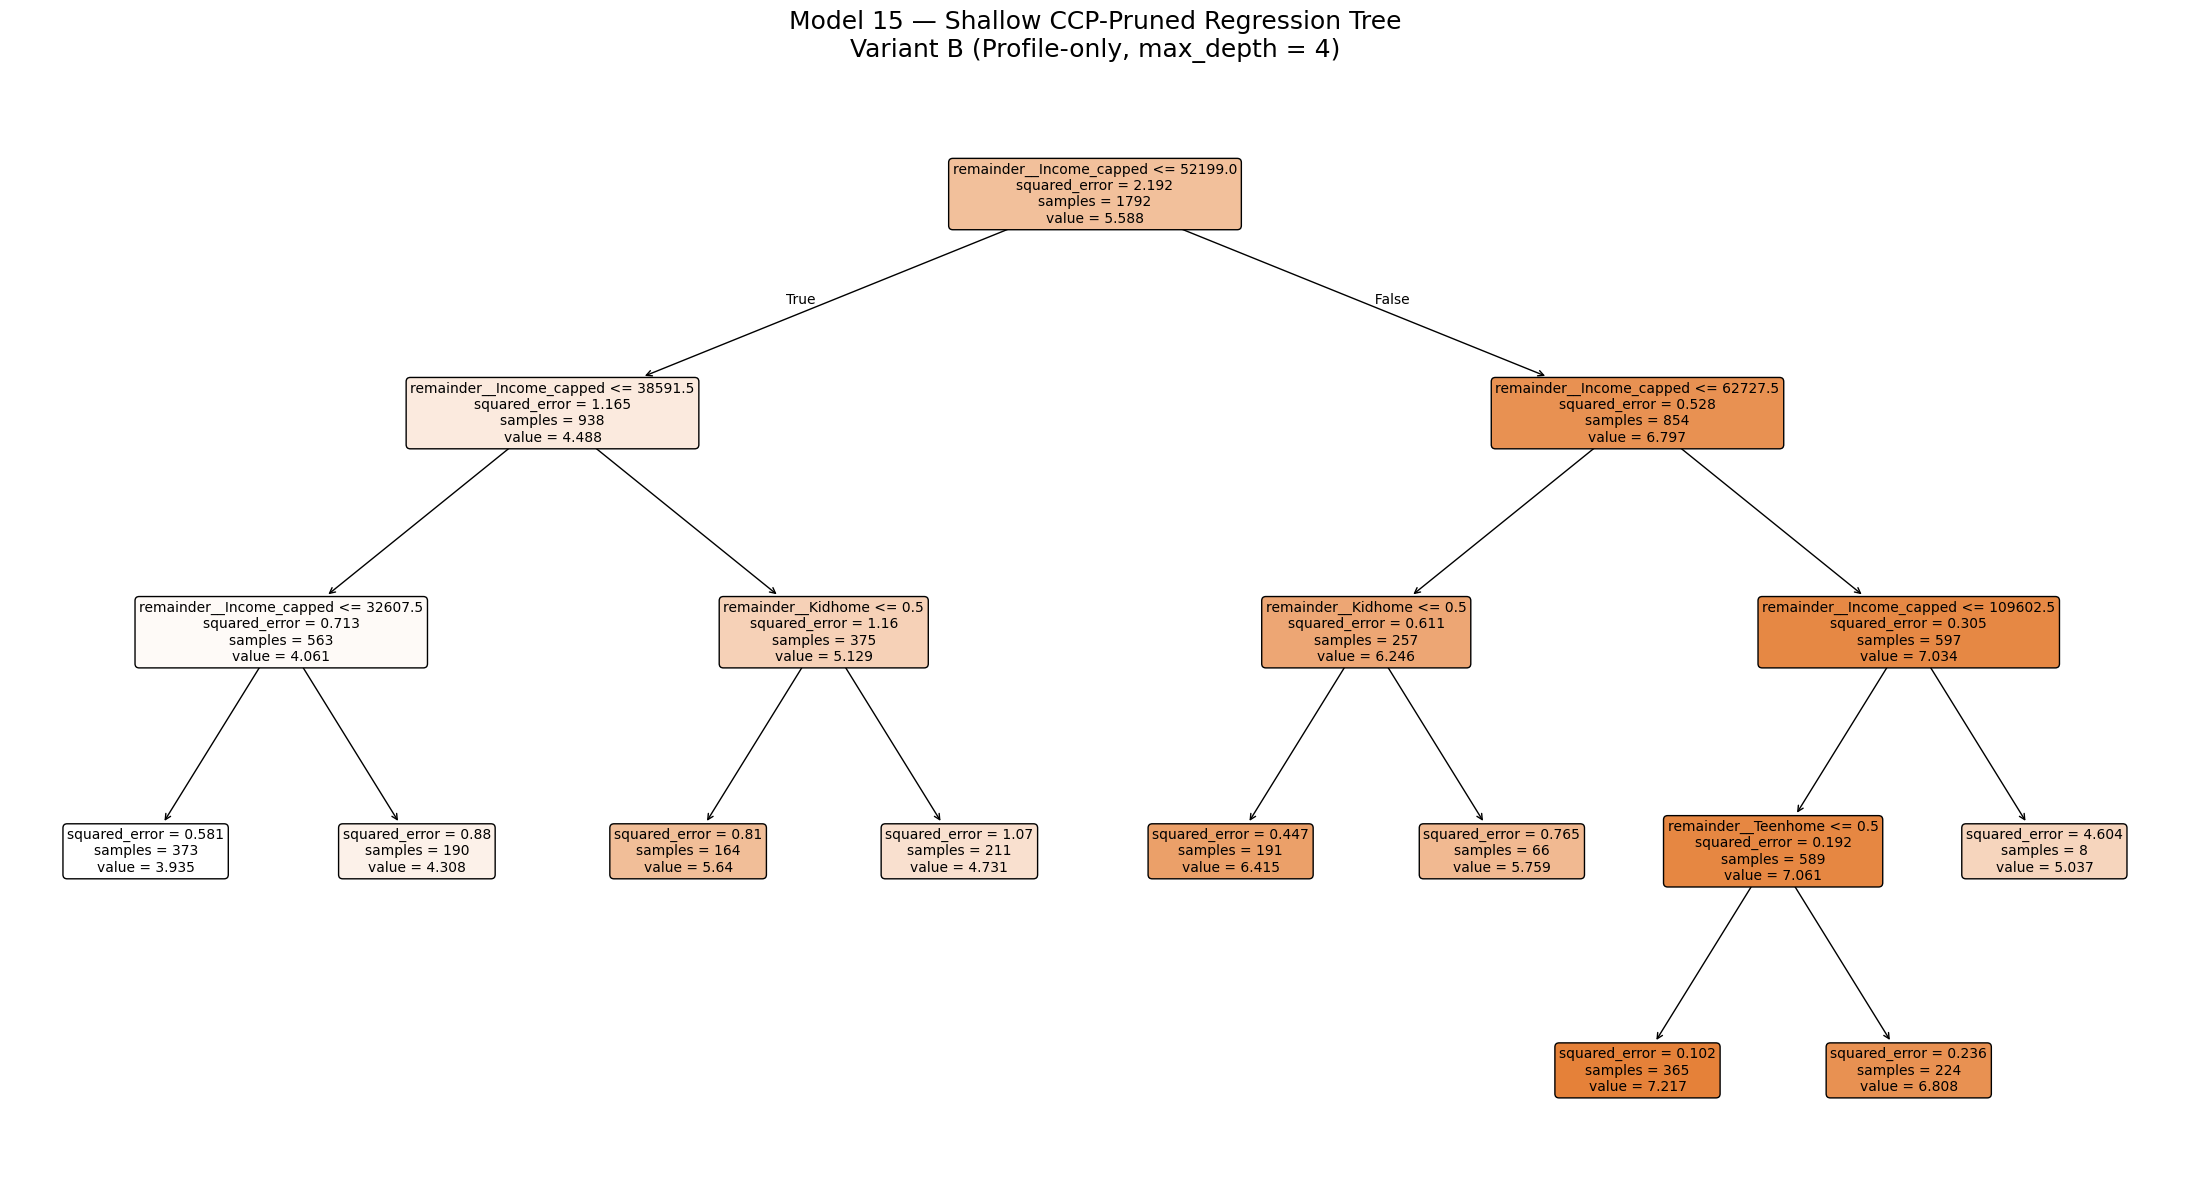

In [613]:
# ============================================================
# Optional — Visualize a shallow version of Model 15
# Variant B: Profile-only feature set
# ============================================================

from sklearn.tree import plot_tree, DecisionTreeRegressor
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Get fitted preprocessor and tree from Model 15 (Variant B)
# ------------------------------------------------------------
prep = pipe_tree.named_steps["pre"]
tree_final = pipe_tree.named_steps["tree"]

# Feature names after preprocessing (numeric + OHE)
feature_names = prep.get_feature_names_out()

# ------------------------------------------------------------
# 2) Build a shallow tree using SAME ccp_alpha (Variant B)
# ------------------------------------------------------------
shallow_tree = DecisionTreeRegressor(
    random_state=42,
    ccp_alpha=tree_final.ccp_alpha,  # = 0.008489
    max_depth=4                      # force interpretability
)

# ------------------------------------------------------------
# 3) Fit shallow tree on PREPROCESSED training data
# ------------------------------------------------------------
X_train_trans = prep.transform(X_train_m15)
shallow_tree.fit(X_train_trans, y_train_m15)

# ------------------------------------------------------------
# 4) Plot the shallow tree
# ------------------------------------------------------------
plt.figure(figsize=(22, 12))
plot_tree(
    shallow_tree,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title(
    "Model 15 — Shallow CCP-Pruned Regression Tree\n"
    "Variant B (Profile-only, max_depth = 4)",
    fontsize=18,
    pad=20
)

plt.tight_layout()
plt.show()


## 6.Ensemble Tree-Based Models
Single decision trees are interpretable but prone to overfitting and instability.
Ensemble tree-based models combine multiple trees to improve robustness and
generalization.

In this section, ensemble methods are introduced using the same leakage-safe
framework and feature variants (A and B) as before.

### Model 16 — Base Random Forest Regressor

(200 trees, OOB, leakage-safe)

#### 🔹 Variant A — Profile + Behavioral feature set

In [614]:
# ============================================================
# Model 16 — Base Random Forest (Behavioral features)
# ============================================================

# ------------------------------------------------------------
# Features — Variant A (Behavioral)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m16 = X_train[num_cols + cat_cols]
X_test_m16  = X_test[num_cols + cat_cols]

y_train_m16 = y_train_log
y_test_m16  = y_test_log

# ------------------------------------------------------------
# Preprocessing (OHE only for categorical)
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Random Forest
# ------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("rf", rf)
    ]
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_rf.fit(X_train_m16, y_train_m16)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_rf.predict(X_train_m16)
y_test_pred  = pipe_rf.predict(X_test_m16)

r2_train = r2_score(y_train_m16, y_train_pred)
r2_test  = r2_score(y_test_m16, y_test_pred)
mse_train = mean_squared_error(y_train_m16, y_train_pred)
mse_test  = mean_squared_error(y_test_m16, y_test_pred)
oob_r2 = pipe_rf.named_steps["rf"].oob_score_

# ------------------------------------------------------------
# Feature count (AFTER preprocessing)
# ------------------------------------------------------------
feature_count = len(
    pipe_rf
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 16 — Base Random Forest",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=oob_r2,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="200 trees, OOB score, OHE-expanded feature space"
)

print("Model 16 — Base Random Forest")
print(f"OOB R²   : {oob_r2:.3f}")
print(f"R² test  : {r2_test:.3f}")
print(f"R² train : {r2_train:.3f}")


Model 16 — Base Random Forest
OOB R²   : 0.959
R² test  : 0.972
R² train : 0.994


#### 🔹 Variant B — Profile-only feature set

In [615]:
# ============================================================
# Model 16 — Base Random Forest (Profile-only)
# ============================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------------------------------
# Features — Variant B (Profile-only)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m16 = X_train[num_cols + cat_cols]
X_test_m16  = X_test[num_cols + cat_cols]

y_train_m16 = y_train_log
y_test_m16  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Random Forest
# ------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("rf", rf)
    ]
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_rf.fit(X_train_m16, y_train_m16)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_rf.predict(X_train_m16)
y_test_pred  = pipe_rf.predict(X_test_m16)

r2_train = r2_score(y_train_m16, y_train_pred)
r2_test  = r2_score(y_test_m16, y_test_pred)
mse_train = mean_squared_error(y_train_m16, y_train_pred)
mse_test  = mean_squared_error(y_test_m16, y_test_pred)
oob_r2 = pipe_rf.named_steps["rf"].oob_score_

# ------------------------------------------------------------
# Feature count (AFTER preprocessing)
# ------------------------------------------------------------
feature_count = len(
    pipe_rf
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 16 — Base Random Forest",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=oob_r2,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="200 trees, OOB score, OHE-expanded feature space"
)


print("Model 16 — Base Random Forest")
print(f"OOB R²   : {oob_r2:.3f}")
print(f"R² test  : {r2_test:.3f}")
print(f"R² train : {r2_train:.3f}")


Model 16 — Base Random Forest
OOB R²   : 0.720
R² test  : 0.729
R² train : 0.962


### Model 17 — Tuned Random Forest Regressor (GridSearchCV)

#### 🔹 Variant A — Profile + Behavioral feature set

In [616]:
# ============================================================
# Model 17 — Tuned Random Forest (Behavioral)
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m17 = X_train[num_cols + cat_cols]
X_test_m17  = X_test[num_cols + cat_cols]

y_train_m17 = y_train_log
y_test_m17  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Base Random Forest
# ------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("rf", rf)
    ]
)

# ------------------------------------------------------------
# Hyperparameter grid
# ------------------------------------------------------------
param_grid = {
    "rf__max_depth": [None, 10, 15, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
grid.fit(X_train_m17, y_train_m17)

best_model = grid.best_estimator_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m17)
y_test_pred  = best_model.predict(X_test_m17)

r2_train = r2_score(y_train_m17, y_train_pred)
r2_test  = r2_score(y_test_m17, y_test_pred)
mse_train = mean_squared_error(y_train_m17, y_train_pred)
mse_test  = mean_squared_error(y_test_m17, y_test_pred)

oob_r2 = best_model.named_steps["rf"].oob_score_

# feature count AFTER OHE
feature_count = len(
    best_model.named_steps["pre"].get_feature_names_out()
)

# ------------------------------------------------------------
#  Report
# ------------------------------------------------------------
forest = best_model.named_steps["rf"]

best_params = grid.best_params_
best_cv_r2  = grid.best_score_
oob_r2      = forest.oob_score_

# diagnostics (average over trees)
tree_depths = [est.tree_.max_depth for est in forest.estimators_]
leaf_counts = [(est.tree_.children_left == -1).sum() for est in forest.estimators_]

mean_depth  = float(np.mean(tree_depths))
mean_leaves = float(np.mean(leaf_counts))

print("🌲 Model 17 — Tuned Random Forest (GridSearchCV)")
print(f"Best params:                 {best_params}")
print(f"OOB R²:                      {oob_r2:.3f}")
print(f"R² (train):                  {r2_train:.3f}")
print(f"R² (test):                   {r2_test:.3f}")
print(f"Best CV R² (5-fold):         {best_cv_r2:.3f}")
print(f"MSE (train):                 {mse_train:.3f}")
print(f"MSE (test):                  {mse_test:.3f}")
print(f"Mean tree depth:             {mean_depth:.1f}")
print(f"Mean leaf nodes per tree:    {mean_leaves:.1f}")
print(f"Total features after OHE:    {feature_count}")

# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 17 — Tuned Random Forest",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=grid.best_score_,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes=f"OOB R²={oob_r2:.3f}, GridSearchCV"
)


🌲 Model 17 — Tuned Random Forest (GridSearchCV)
Best params:                 {'rf__max_depth': 15, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}
OOB R²:                      0.958
R² (train):                  0.994
R² (test):                   0.972
Best CV R² (5-fold):         0.959
MSE (train):                 0.013
MSE (test):                  0.058
Mean tree depth:             15.0
Mean leaf nodes per tree:    947.3
Total features after OHE:    27


#### 🌲 Feature Importance + Barplot Variant A — Behavioral (Model 17A)

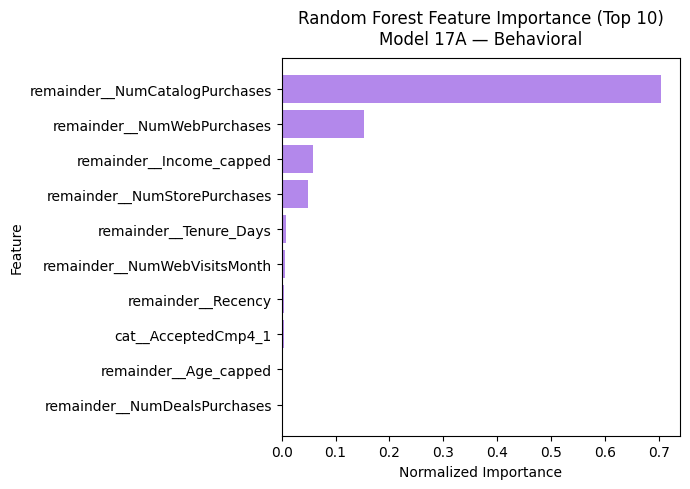

In [617]:
# ============================================================
# 🌲 Feature Importance — Random Forest (Variant A: Behavioral)
# Model 17A
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Get preprocessor & forest
# ------------------------------------------------------------
preprocessor_A = best_model.named_steps["pre"]
forest_A = best_model.named_steps["rf"]

# ------------------------------------------------------------
# Feature names & importances
# ------------------------------------------------------------
feature_names_A = preprocessor_A.get_feature_names_out()
importances_A = forest_A.feature_importances_

feat_imp_A = (
    pd.DataFrame({
        "feature": feature_names_A,
        "importance": importances_A
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feat_imp_A["importance_norm"] = (
    feat_imp_A["importance"] / feat_imp_A["importance"].sum()
)

# ------------------------------------------------------------
# Barplot (Top K)
# ------------------------------------------------------------
TOP_K = 10
top_feat_A = feat_imp_A.head(TOP_K).iloc[::-1]

plt.figure(figsize=(7, 5))
plt.barh(top_feat_A["feature"], top_feat_A["importance_norm"], color = "#B388EB")
plt.title(
    "Random Forest Feature Importance (Top 10)\nModel 17A — Behavioral",
    pad=10
)
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#### 🔹 Variant B — Profile-only feature set

In [ ]:
# ============================================================
# Model 17 — Tuned Random Forest (Profile-only)
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m17 = X_train[num_cols + cat_cols]
X_test_m17  = X_test[num_cols + cat_cols]

y_train_m17 = y_train_log
y_test_m17  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

rf = RandomForestRegressor(
    n_estimators=200,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("rf", rf)
    ]
)

param_grid = {
    "rf__max_depth": [None, 8, 12, 16],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
grid.fit(X_train_m17, y_train_m17)

best_model = grid.best_estimator_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m17)
y_test_pred  = best_model.predict(X_test_m17)

r2_train = r2_score(y_train_m17, y_train_pred)
r2_test  = r2_score(y_test_m17, y_test_pred)
mse_train = mean_squared_error(y_train_m17, y_train_pred)
mse_test  = mean_squared_error(y_test_m17, y_test_pred)

oob_r2 = best_model.named_steps["rf"].oob_score_

feature_count = len(
    best_model.named_steps["pre"].get_feature_names_out()
)

# ------------------------------------------------------------
# Report
# ------------------------------------------------------------
forest = best_model.named_steps["rf"]

best_params = grid.best_params_
best_cv_r2  = grid.best_score_
oob_r2      = forest.oob_score_

# diagnostics (average over trees)
tree_depths = [est.tree_.max_depth for est in forest.estimators_]
leaf_counts = [(est.tree_.children_left == -1).sum() for est in forest.estimators_]

mean_depth  = float(np.mean(tree_depths))
mean_leaves = float(np.mean(leaf_counts))

print("🌲 Model 17 — Tuned Random Forest(GridSearchCV)")
print(f"Best params:                 {best_params}")
print(f"OOB R²:                      {oob_r2:.3f}")
print(f"R² (train):                  {r2_train:.3f}")
print(f"R² (test):                   {r2_test:.3f}")
print(f"Best CV R² (5-fold):         {best_cv_r2:.3f}")
print(f"MSE (train):                 {mse_train:.3f}")
print(f"MSE (test):                  {mse_test:.3f}")
print(f"Mean tree depth:             {mean_depth:.1f}")
print(f"Mean leaf nodes per tree:    {mean_leaves:.1f}")
print(f"Total features after OHE:    {feature_count}")


# ------------------------------------------------------------
# Log
# ------------------------------------------------------------
log_profile_model(
    name="Model 17 — Tuned Random Forest",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=grid.best_score_,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes=f"OOB R²={oob_r2:.3f}, GridSearchCV"
)


🌲 Model 17 — Tuned Random Forest
Best params:                 {'rf__max_depth': 8, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10}
OOB R²:                      0.740
R² (train):                  0.835
R² (test):                   0.730
Best CV R² (5-fold):         0.744
MSE (train):                 0.362
MSE (test):                  0.546
Mean tree depth:             8.0
Mean leaf nodes per tree:    99.1
Total features after OHE:    13


#### 🌲 Feature Importance + Barplot Variant B — Profile-only (Model 17B)

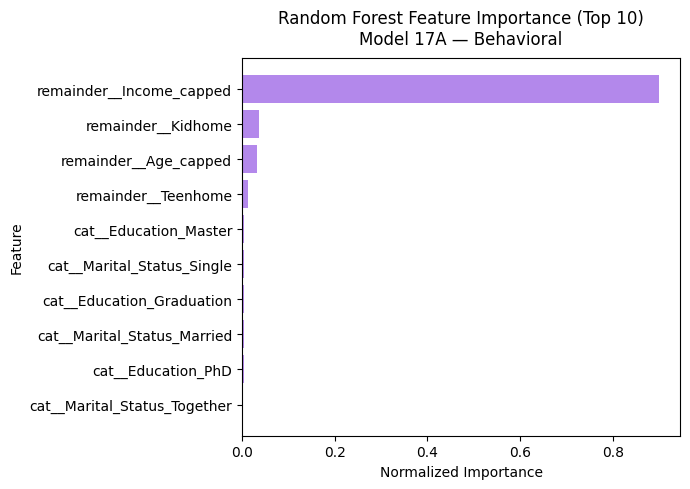

In [619]:
# ============================================================
# 🌲 Feature Importance — Random Forest (Variant A: Behavioral)
# Model 17A
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Get preprocessor & forest
# ------------------------------------------------------------
preprocessor_A = best_model.named_steps["pre"]
forest_A = best_model.named_steps["rf"]

# ------------------------------------------------------------
# Feature names & importances
# ------------------------------------------------------------
feature_names_A = preprocessor_A.get_feature_names_out()
importances_A = forest_A.feature_importances_

feat_imp_A = (
    pd.DataFrame({
        "feature": feature_names_A,
        "importance": importances_A
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feat_imp_A["importance_norm"] = (
    feat_imp_A["importance"] / feat_imp_A["importance"].sum()
)

# ------------------------------------------------------------
# Barplot (Top K)
# ------------------------------------------------------------
TOP_K = 10
top_feat_A = feat_imp_A.head(TOP_K).iloc[::-1]

plt.figure(figsize=(7, 5))
plt.barh(top_feat_A["feature"], top_feat_A["importance_norm"], color = "#B388EB")
plt.title(
    "Random Forest Feature Importance (Top 10)\nModel 17A — Behavioral",
    pad=10
)
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Model 18 — Gradient Boosting Regressor (Baseline)

#### 🔹 Variant A — Profile + Behavioral feature set

In [620]:
# ============================================================
# Model 18 — Gradient Boosting Regressor
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m18 = X_train[num_cols + cat_cols]
X_test_m18  = X_test[num_cols + cat_cols]

y_train_m18 = y_train_log
y_test_m18  = y_test_log

# ------------------------------------------------------------
# Preprocessing (OHE only for categoricals)
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Gradient Boosting (baseline)
# ------------------------------------------------------------
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

pipe_gbr = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("gbr", gbr)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_gbr, X_train_m18, y_train_m18, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_gbr.fit(X_train_m18, y_train_m18)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_gbr.predict(X_train_m18)
y_test_pred  = pipe_gbr.predict(X_test_m18)

r2_train = r2_score(y_train_m18, y_train_pred)
r2_test  = r2_score(y_test_m18, y_test_pred)
mse_train = mean_squared_error(y_train_m18, y_train_pred)
mse_test  = mean_squared_error(y_test_m18, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing (correct)
# ------------------------------------------------------------
feature_names = (
    pipe_gbr
    .named_steps["pre"]
    .get_feature_names_out()
)

feature_count = len(feature_names)
# --

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 18 — Gradient Boosting",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Baseline Gradient Boosting, behavioral features"
)

print("Model 18 — Gradient Boosting")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 18 — Gradient Boosting
R² test : 0.967
R² train: 0.978
R² CV   : 0.958


#### 🔹 Variant B — Profile-only feature set

In [621]:
# ============================================================
# Model 18 — Gradient Boosting Regressor
# Variant B: Profile-only feature set
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m18 = X_train[num_cols + cat_cols]
X_test_m18  = X_test[num_cols + cat_cols]

y_train_m18 = y_train_log
y_test_m18  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# Gradient Boosting (baseline)
# ------------------------------------------------------------
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

pipe_gbr = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("gbr", gbr)
    ]
)

# ------------------------------------------------------------
# CV (train only)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_cv = cross_val_score(
    pipe_gbr, X_train_m18, y_train_m18, cv=cv, scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
pipe_gbr.fit(X_train_m18, y_train_m18)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = pipe_gbr.predict(X_train_m18)
y_test_pred  = pipe_gbr.predict(X_test_m18)

r2_train = r2_score(y_train_m18, y_train_pred)
r2_test  = r2_score(y_test_m18, y_test_pred)
mse_train = mean_squared_error(y_train_m18, y_train_pred)
mse_test  = mean_squared_error(y_test_m18, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing (correct)
# ------------------------------------------------------------
feature_names = (
    pipe_gbr
    .named_steps["pre"]
    .get_feature_names_out()
)

feature_count = len(feature_names)
# ------------------------------------------------------------

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 18 — Gradient Boosting",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="Baseline Gradient Boosting, profile-only features"
)

print("Model 18 — Gradient Boosting")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 18 — Gradient Boosting
R² test : 0.732
R² train: 0.813
R² CV   : 0.744


### Model 19 — XGBoost Regressor (Tuned, CV)

#### 🔹 Variant A — Profile + Behavioral feature set

In [622]:
# ============================================================
# Model 19 — XGBoost Regressor
# Variant A: Behavioral feature set
# ============================================================

# ------------------------------------------------------------
# Features (Behavioral)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Tenure_Days",
    "Recency",
    "Kidhome",
    "Teenhome",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth"
]

cat_cols = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response"
]

X_train_m19 = X_train[num_cols + cat_cols]
X_test_m19  = X_test[num_cols + cat_cols]

y_train_m19 = y_train_log
y_test_m19  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# ------------------------------------------------------------
# XGBoost + GridSearchCV
# ------------------------------------------------------------
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("xgb", xgb)
])

param_grid = {
    "xgb__n_estimators": [300, 500],
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
grid.fit(X_train_m19, y_train_m19)

best_model = grid.best_estimator_
best_cv = grid.best_score_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m19)
y_test_pred  = best_model.predict(X_test_m19)

r2_train = r2_score(y_train_m19, y_train_pred)
r2_test  = r2_score(y_test_m19, y_test_pred)
mse_train = mean_squared_error(y_train_m19, y_train_pred)
mse_test  = mean_squared_error(y_test_m19, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing (correct)
# ------------------------------------------------------------
feature_names = (
    pipe_gbr
    .named_steps["pre"]
    .get_feature_names_out()
)

feature_count = len(feature_names)
# ------------------------------------------------------------

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 19 — XGBoost",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="XGBoost, tuned, behavioral feature set"
)

print("Model 19 — XGBoost")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {best_cv:.3f}")


Model 19 — XGBoost
R² test : 0.973
R² train: 0.994
R² CV   : 0.965


#### 🔹 Variant B — Profile-only feature set

In [623]:
# ============================================================
# Model 19 — XGBoost Regressor
# Variant B: Profile-only feature set
# ============================================================

num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome"
]

cat_cols = [
    "Education",
    "Marital_Status"
]

X_train_m19 = X_train[num_cols + cat_cols]
X_test_m19  = X_test[num_cols + cat_cols]

y_train_m19 = y_train_log
y_test_m19  = y_test_log

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("xgb", xgb)
])

param_grid = {
    "xgb__n_estimators": [200, 400],
    "xgb__max_depth": [2, 3],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train_m19, y_train_m19)

best_model = grid.best_estimator_
best_cv = grid.best_score_

y_train_pred = best_model.predict(X_train_m19)
y_test_pred  = best_model.predict(X_test_m19)

r2_train = r2_score(y_train_m19, y_train_pred)
r2_test  = r2_score(y_test_m19, y_test_pred)
mse_train = mean_squared_error(y_train_m19, y_train_pred)
mse_test  = mean_squared_error(y_test_m19, y_test_pred)

# ------------------------------------------------------------
# Feature count AFTER preprocessing (correct)
# ------------------------------------------------------------
feature_names = (
    pipe_gbr
    .named_steps["pre"]
    .get_feature_names_out()
)

feature_count = len(feature_names)
# ------------------------------------------------------------

log_profile_model(
    name="Model 19 — XGBoost",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=best_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="XGBoost, tuned, profile-only features"
)

print("Model 19 — XGBoost")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {best_cv:.3f}")


Model 19 — XGBoost
R² test : 0.735
R² train: 0.779
R² CV   : 0.749


## 5. Kernel-Based Model

### Model 20 — SVR (RBF)(Lasso-selected features)

#### 🔹 Variant A — Profile + Behavioral feature set

In [624]:
# ============================================================
# Model 20 — SVR (RBF)
# Variant A: Behavioral (Lasso-selected features)
# ============================================================

# ------------------------------------------------------------
# Features (BEHAVIORAL — Lasso-selected)
# ------------------------------------------------------------
num_cols = [
    "NumCatalogPurchases",
    "Income_capped",
    "NumWebPurchases",
    "NumStorePurchases",
    "Kidhome",
    "NumDealsPurchases",
    "Teenhome",
    "Tenure_Days",
]

X_train_m20 = X_train[num_cols]
X_test_m20  = X_test[num_cols]

y_train_m20 = y_train_log
y_test_m20  = y_test_log

# ------------------------------------------------------------
# Preprocessing (scaling REQUIRED for SVR)
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)

# ------------------------------------------------------------
# SVR pipeline
# ------------------------------------------------------------
pipe_svr = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("svr", SVR(kernel="rbf")),
    ]
)

# ------------------------------------------------------------
# GridSearchCV
# ------------------------------------------------------------
param_grid = {
    "svr__C": [0.1, 1, 10],
    "svr__gamma": ["scale", 0.1, 0.01],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_svr,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
grid.fit(X_train_m20, y_train_m20)

best_model = grid.best_estimator_
r2_cv = grid.best_score_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m20)
y_test_pred  = best_model.predict(X_test_m20)

r2_train = r2_score(y_train_m20, y_train_pred)
r2_test  = r2_score(y_test_m20, y_test_pred)
mse_train = mean_squared_error(y_train_m20, y_train_pred)
mse_test  = mean_squared_error(y_test_m20, y_test_pred)

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 20 — SVR (RBF on Lasso-selected features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=len(num_cols),
    notes="SVR with RBF kernel on Lasso-selected behavioral features"
)

print("Model 20 — SVR (RBF on Lasso-selected features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 20 — SVR (RBF on Lasso-selected features)
R² test : 0.968
R² train: 0.973
R² CV   : 0.950


#### 🔹 Variant B — Profile-only feature set

In [625]:
# ============================================================
# Model 20 — SVR (RBF)
# Variant B: Profile-only
# ============================================================

# ------------------------------------------------------------
# Features (PROFILE-ONLY)
# ------------------------------------------------------------
num_cols = [
    "Income_capped",
    "Age_capped",
    "Kidhome",
    "Teenhome",
]

X_train_m20 = X_train[num_cols]
X_test_m20  = X_test[num_cols]

y_train_m20 = y_train_log
y_test_m20  = y_test_log

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)

pipe_svr = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("svr", SVR(kernel="rbf")),
    ]
)

param_grid = {
    "svr__C": [0.1, 1, 10],
    "svr__gamma": ["scale", 0.1, 0.01],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_svr,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# Fit
# ------------------------------------------------------------
grid.fit(X_train_m20, y_train_m20)

best_model = grid.best_estimator_
r2_cv = grid.best_score_

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_m20)
y_test_pred  = best_model.predict(X_test_m20)

r2_train = r2_score(y_train_m20, y_train_pred)
r2_test  = r2_score(y_test_m20, y_test_pred)
mse_train = mean_squared_error(y_train_m20, y_train_pred)
mse_test  = mean_squared_error(y_test_m20, y_test_pred)

# ------------------------------------------------------------
# Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 20 — SVR (RBF on Lasso-selected features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=len(num_cols),
    notes="SVR with RBF kernel on profile-only features"
)

print("Model 20 — SVR (RBF on Lasso-selected features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")


Model 20 — SVR (RBF on Lasso-selected features)
R² test : 0.740
R² train: 0.767
R² CV   : 0.745


### Model 21 — SVR (RBF)(on Polynomial Lasso–selected features)

#### 🔹 Variant A — Profile + Behavioral feature set

In [626]:
# ============================================================
# Model 21 — SVR (RBF)
# Variant A: Polynomial Lasso-selected (Behavioral)
# ============================================================

# ------------------------------------------------------------
# 1) Polynomial feature space (from Model 10A)
# ------------------------------------------------------------
X_train_poly = (
    pipe_lasso_poly_fixed_behavioral
    .named_steps["pre"]
    .transform(X_train_m10_A)
)

X_test_poly = (
    pipe_lasso_poly_fixed_behavioral
    .named_steps["pre"]
    .transform(X_test_m10_A)
)

feature_names_poly = (
    pipe_lasso_poly_fixed_behavioral
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# 2) Select polynomial features kept by Lasso
# ------------------------------------------------------------
coefs = pipe_lasso_poly_fixed_behavioral.named_steps["lasso"].coef_

selected_idx = [i for i, c in enumerate(coefs) if abs(c) > 1e-8]

X_train_sel = X_train_poly[:, selected_idx]
X_test_sel  = X_test_poly[:, selected_idx]

feature_count = len(selected_idx)

y_train_m21 = y_train_log
y_test_m21  = y_test_log

# ------------------------------------------------------------
# 3) Scaling (SVR requires scaling)
# ------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

# ------------------------------------------------------------
# 4) SVR + GridSearchCV
# ------------------------------------------------------------
svr = SVR(kernel="rbf")

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    svr,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# 5) Fit
# ------------------------------------------------------------
grid.fit(X_train_scaled, y_train_m21)

best_model = grid.best_estimator_
r2_cv = grid.best_score_

# ------------------------------------------------------------
# 6) Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred  = best_model.predict(X_test_scaled)

r2_train = r2_score(y_train_m21, y_train_pred)
r2_test  = r2_score(y_test_m21, y_test_pred)
mse_train = mean_squared_error(y_train_m21, y_train_pred)
mse_test  = mean_squared_error(y_test_m21, y_test_pred)

# ------------------------------------------------------------
# 7) Log + Print
# ------------------------------------------------------------
log_behavioral_model(
    name="Model 21 — SVR (Poly Lasso-selected features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="SVR (RBF) on polynomial features selected by Lasso (Model 10A)"
)

print("Model 21 — SVR (Poly Lasso-selected features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"Final feature count: {feature_count}")


Model 21 — SVR (Poly Lasso-selected features)
R² test : 0.963
R² train: 0.969
R² CV   : 0.957
Final feature count: 22


#### 🔹 Variant B — Profile-only feature set

In [627]:
# ============================================================
# Model 21 — SVR (RBF)
# Variant B: Polynomial Lasso-selected (Profile-only)
# ============================================================

# ------------------------------------------------------------
# 1) Polynomial feature space (from Model 10B)
# ------------------------------------------------------------
X_train_poly = (
    pipe_lasso_poly_fixed_profile
    .named_steps["pre"]
    .transform(X_train_m10_B)
)

X_test_poly = (
    pipe_lasso_poly_fixed_profile
    .named_steps["pre"]
    .transform(X_test_m10_B)
)

feature_names_poly = (
    pipe_lasso_poly_fixed_profile
    .named_steps["pre"]
    .get_feature_names_out()
)

# ------------------------------------------------------------
# 2) Select polynomial features kept by Lasso
# ------------------------------------------------------------
coefs = pipe_lasso_poly_fixed_profile.named_steps["lasso"].coef_

selected_idx = [i for i, c in enumerate(coefs) if abs(c) > 1e-8]

X_train_sel = X_train_poly[:, selected_idx]
X_test_sel  = X_test_poly[:, selected_idx]

feature_count = len(selected_idx)

y_train_m21 = y_train_log
y_test_m21  = y_test_log

# ------------------------------------------------------------
# 3) Scaling
# ------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

# ------------------------------------------------------------
# 4) SVR + GridSearchCV
# ------------------------------------------------------------
svr = SVR(kernel="rbf")

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    svr,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# ------------------------------------------------------------
# 5) Fit
# ------------------------------------------------------------
grid.fit(X_train_scaled, y_train_m21)

best_model = grid.best_estimator_
r2_cv = grid.best_score_

# ------------------------------------------------------------
# 6) Metrics
# ------------------------------------------------------------
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred  = best_model.predict(X_test_scaled)

r2_train = r2_score(y_train_m21, y_train_pred)
r2_test  = r2_score(y_test_m21, y_test_pred)
mse_train = mean_squared_error(y_train_m21, y_train_pred)
mse_test  = mean_squared_error(y_test_m21, y_test_pred)

# ------------------------------------------------------------
# 7) Log + Print
# ------------------------------------------------------------
log_profile_model(
    name="Model 21 — SVR (Poly Lasso-selected features)",
    r2_train=r2_train,
    r2_test=r2_test,
    r2_cv=r2_cv,
    mse_train=mse_train,
    mse_test=mse_test,
    feature_count=feature_count,
    notes="SVR (RBF) on polynomial features selected by Lasso (Model 10B)"
)

print("Model 21 — SVR (Poly Lasso-selected features)")
print(f"R² test : {r2_test:.3f}")
print(f"R² train: {r2_train:.3f}")
print(f"R² CV   : {r2_cv:.3f}")
print(f"Final feature count: {feature_count}")


Model 21 — SVR (Poly Lasso-selected features)
R² test : 0.741
R² train: 0.763
R² CV   : 0.746
Final feature count: 7


### 📋 Final Summary — Behavioral Regression Models

#### Table 1 — Behavioral Regression Models in Order of Development

In [628]:
# ============================================
# 📋 Regression Models – Behavioral Summary
# ============================================

import pandas as pd

df_behavioral = pd.DataFrame(behavioral_log)

summary_cols = [
    "Model",
    "R²_train",
    "R²_test",
    "R²_CV",
    "MSE_test",
    "MSE_train",
    "Feature_count"
]

df_behavioral = df_behavioral[summary_cols]

print("📊 Behavioral Models Summary:")
display(df_behavioral)


📊 Behavioral Models Summary:


,Model,R²_train,R²_test,R²_CV,MSE_test,MSE_train,Feature_count
0,Model 1 — Linear Regression(Baseline),0.876,0.879,0.867,0.24,0.27,27
1,Model 2 — Linear Regression (EDA-based features),0.864,0.863,0.856,0.28,0.30,21
2,Model 3 — Ridge Regression,0.875,0.881,0.868,0.24,0.27,27
3,Model 4 — LassoCV,0.876,0.880,0.867,0.24,0.27,24
4,Model 5 — LassoCV (Fixed Alpha),0.868,0.877,0.862,0.25,0.29,8
5,Model 6 — Linear Regression (Lasso-selected),0.870,0.882,0.864,0.24,0.28,8
6,Model 7 — Polynomial Linear Regression,0.961,0.958,0.933,0.09,0.08,93
7,Model 8 — Polynomial Ridge Regression,0.960,0.956,0.934,0.09,0.09,93
8,Model 9 — Polynomial LassoCV,0.956,0.953,0.940,0.09,0.10,51
9,Model 10 — Polynomial Lasso (fixed α),0.929,0.933,0.922,0.14,0.16,22


#### Table 2 — Behavioral Models Ranked by Test R² (Color-Coded by Model Family)

📋 behavioral-only Models — Sorted by R²_test


,Model,R²_train,R²_test,R²_CV,MSE_test,MSE_train,Feature_count,model_id,Model_Family
0,Model 19 — XGBoost,0.994,0.973,0.965,0.05,0.01,13,19,4. Ensemble Tree-Based
1,Model 17 — Tuned Random Forest,0.994,0.972,0.959,0.06,0.01,27,17,4. Ensemble Tree-Based
2,Model 16 — Base Random Forest,0.994,0.972,0.959,0.06,0.01,27,16,4. Ensemble Tree-Based
3,Model 20 — SVR (RBF on Lasso-selected features),0.973,0.968,0.950,0.06,0.06,8,20,5. Kernel-Based
4,Model 18 — Gradient Boosting,0.978,0.967,0.958,0.07,0.05,27,18,4. Ensemble Tree-Based
5,Model 21 — SVR (Poly Lasso-selected features),0.969,0.963,0.957,0.07,0.07,22,21,5. Kernel-Based
6,Model 7 — Polynomial Linear Regression,0.961,0.958,0.933,0.09,0.08,93,7,2. Polynomial Regression
7,Model 8 — Polynomial Ridge Regression,0.960,0.956,0.934,0.09,0.09,93,8,2. Polynomial Regression
8,Model 13 — Tuned Regression Tree,0.968,0.956,0.943,0.09,0.07,27,13,3. Decision Tree
9,Model 9 — Polynomial LassoCV,0.956,0.953,0.940,0.09,0.10,51,9,2. Polynomial Regression


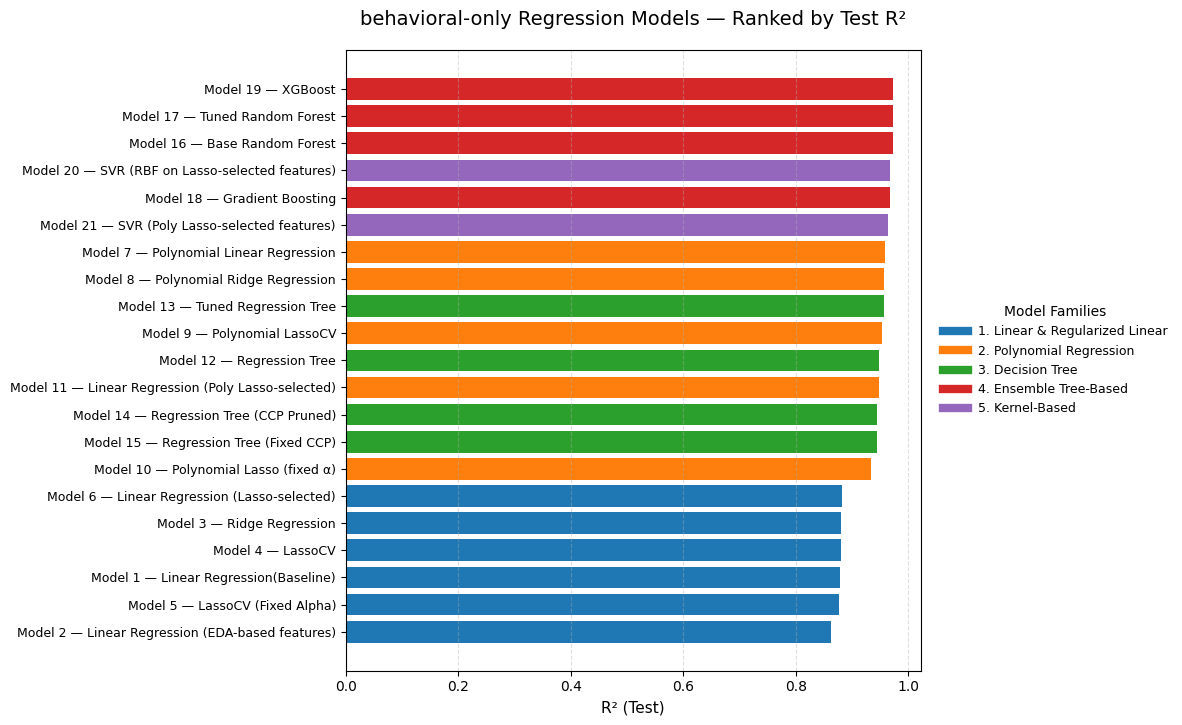

In [ ]:

# ------------------------------------------------
# 1) Copy table (safe)
# ------------------------------------------------
df = df_behavioral.copy()

# ------------------------------------------------
# 2) Extract model number from Model name
# ------------------------------------------------
def extract_model_id(model_name):
    match = re.search(r"Model\s+(\d+)", model_name)
    return int(match.group(1)) if match else None

df["model_id"] = df["Model"].apply(extract_model_id)

# ------------------------------------------------
# 3) Assign model family
# ------------------------------------------------
def model_family(model_id):
    if model_id is None:
        return "Other"
    elif 1 <= model_id <= 6:
        return "1. Linear & Regularized Linear"
    elif 7 <= model_id <= 11:
        return "2. Polynomial Regression"
    elif 12 <= model_id <= 15:
        return "3. Decision Tree"
    elif 16 <= model_id <= 19:
        return "4. Ensemble Tree-Based"
    elif 20 <= model_id <= 21:
        return "5. Kernel-Based"
    else:
        return "Other"

df["Model_Family"] = df["model_id"].apply(model_family)

# ------------------------------------------------
# 4) Sort by R²_test
# ------------------------------------------------
df_sorted = (
    df
    .sort_values("R²_test", ascending=False)
    .reset_index(drop=True)
)

print("📋 behavioral-only Models — Sorted by R²_test")
display(df_sorted)

# ------------------------------------------------
# 5) Color mapping
# ------------------------------------------------
family_colors = {
    "1. Linear & Regularized Linear": "#1f77b4",
    "2. Polynomial Regression": "#ff7f0e",
    "3. Decision Tree": "#2ca02c",
    "4. Ensemble Tree-Based": "#d62728",
    "5. Kernel-Based": "#9467bd",
    "Other": "#7f7f7f"
}

bar_colors = df_sorted["Model_Family"].map(family_colors)
# ------------------------------------------------
# 6) Plot (ELEGANT FIX)
# ------------------------------------------------
n_models = len(df_sorted)
fig_height = max(5, n_models * 0.35)

plt.figure(figsize=(12, fig_height))

plt.barh(
    df_sorted["Model"],
    df_sorted["R²_test"],
    color=bar_colors
)

plt.gca().invert_yaxis()

plt.xlabel("R² (Test)", fontsize=11)
plt.ylabel("")
plt.title(
    "behavioral-only Regression Models — Ranked by Test R²",
    fontsize=14,
    pad=18
)

plt.grid(
    axis="x",
    linestyle="--",
    alpha=0.4
)

plt.yticks(fontsize=9)
plt.xticks(fontsize=10)

# ------------------------------------------------
# 7) Legend (outside)
# ------------------------------------------------
legend_handles = [
    plt.Line2D([0], [0], color=color, lw=6, label=family)
    for family, color in family_colors.items()
    if family in df_sorted["Model_Family"].values
]

plt.legend(
    handles=legend_handles,
    title="Model Families",
    fontsize=9,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()


### 📋 Final Summary — Profile Regression Models
Models are ranked based on their out-of-sample performance (R² on the test set).
Clear performance differences can be observed across model families, with
ensemble and kernel-based models generally outperforming linear approaches,
while simpler models remain competitive given their interpretability and lower complexity.

#### Table 1 — Profile Regression Models in Order of Development

In [630]:
# ============================================
# 📋 Regression Models – Profile-only Summary
# ============================================

df_profile = pd.DataFrame(profile_log)

summary_cols = [
    "Model",
    "R²_train",
    "R²_test",
    "R²_CV",
    "MSE_test",
    "MSE_train",
    "Feature_count"
]

df_profile = df_profile[summary_cols]

print("📊 Profile-only Models Summary:")
display(df_profile)


📊 Profile-only Models Summary:


,Model,R²_train,R²_test,R²_CV,MSE_test,MSE_train,Feature_count
0,Model 1 — Linear Regression(Baseline),0.669,0.671,0.663,0.66,0.73,13
1,Model 2 — Linear Regression (EDA-based features),0.668,0.671,0.663,0.66,0.73,12
2,Model 3 — Ridge Regression,0.668,0.670,0.664,0.67,0.73,13
3,Model 4 — LassoCV,0.667,0.672,0.666,0.66,0.73,5
4,Model 5 — LassoCV (Fixed Alpha),0.666,0.671,0.665,0.67,0.73,3
5,Model 6 — Linear Regression (Lasso-selected),0.667,0.672,0.666,0.66,0.73,3
6,Model 7 — Polynomial Linear Regression,0.725,0.728,0.712,0.55,0.60,23
7,Model 8 — Polynomial Ridge Regression,0.724,0.727,0.713,0.55,0.60,23
8,Model 9 — Polynomial LassoCV,0.723,0.729,0.713,0.55,0.61,14
9,Model 10 — Polynomial Lasso (fixed α),0.709,0.714,0.703,0.58,0.64,7


#### Table 2 — Profile Regression Models Ranked by Test R²

📋 Profile-only Models — Sorted by R²_test


,Model,R²_train,R²_test,R²_CV,MSE_test,MSE_train,Feature_count,model_id,Model_Family
0,Model 21 — SVR (Poly Lasso-selected features),0.763,0.741,0.746,0.52,0.52,7,21,5. Kernel-Based
1,Model 20 — SVR (RBF on Lasso-selected features),0.767,0.740,0.745,0.52,0.51,4,20,5. Kernel-Based
2,Model 19 — XGBoost,0.779,0.735,0.749,0.53,0.48,13,19,4. Ensemble Tree-Based
3,Model 18 — Gradient Boosting,0.813,0.732,0.744,0.54,0.41,13,18,4. Ensemble Tree-Based
4,Model 17 — Tuned Random Forest,0.835,0.730,0.744,0.55,0.36,13,17,4. Ensemble Tree-Based
5,Model 16 — Base Random Forest,0.962,0.729,0.720,0.55,0.08,13,16,4. Ensemble Tree-Based
6,Model 9 — Polynomial LassoCV,0.723,0.729,0.713,0.55,0.61,14,9,2. Polynomial Regression
7,Model 7 — Polynomial Linear Regression,0.725,0.728,0.712,0.55,0.60,23,7,2. Polynomial Regression
8,Model 8 — Polynomial Ridge Regression,0.724,0.727,0.713,0.55,0.60,23,8,2. Polynomial Regression
9,Model 11 — Linear Regression (Poly Lasso-selec...,0.719,0.726,0.714,0.55,0.62,7,11,2. Polynomial Regression


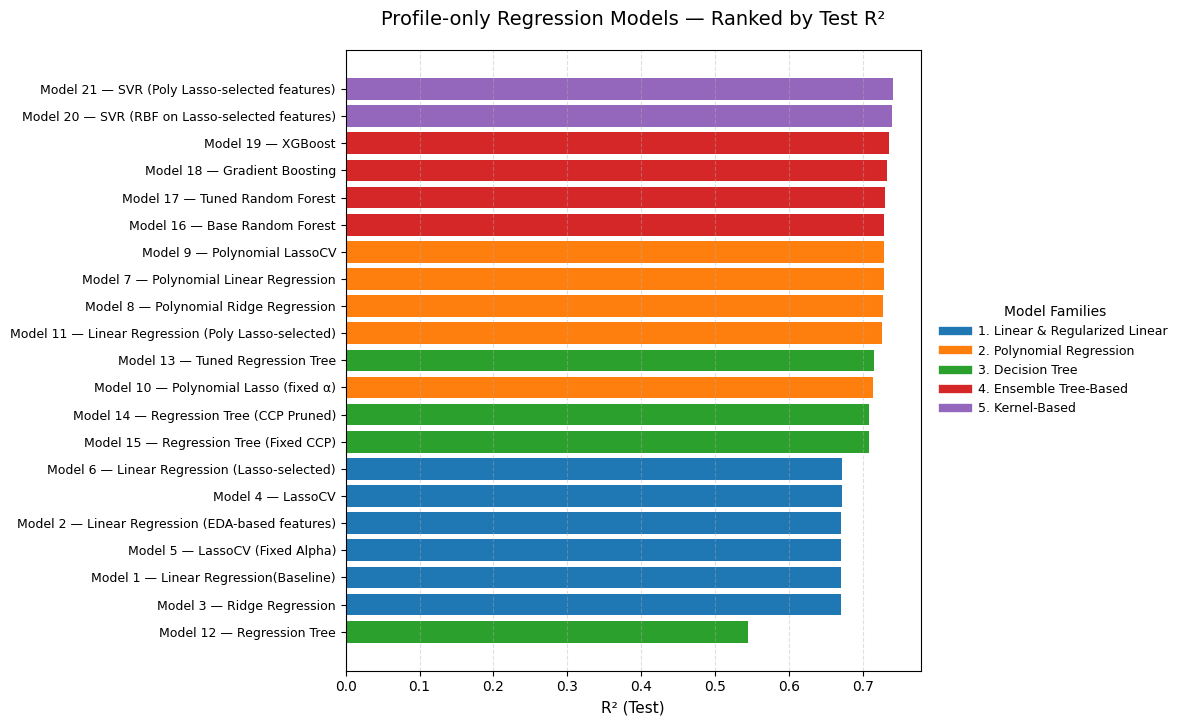

In [ ]:

# ------------------------------------------------
# 1) Copy table (safe)
# ------------------------------------------------
df = df_profile.copy()

# ------------------------------------------------
# 2) Extract model number from Model name
# ------------------------------------------------
def extract_model_id(model_name):
    match = re.search(r"Model\s+(\d+)", model_name)
    return int(match.group(1)) if match else None

df["model_id"] = df["Model"].apply(extract_model_id)

# ------------------------------------------------
# 3) Assign model family
# ------------------------------------------------
def model_family(model_id):
    if model_id is None:
        return "Other"
    elif 1 <= model_id <= 6:
        return "1. Linear & Regularized Linear"
    elif 7 <= model_id <= 11:
        return "2. Polynomial Regression"
    elif 12 <= model_id <= 15:
        return "3. Decision Tree"
    elif 16 <= model_id <= 19:
        return "4. Ensemble Tree-Based"
    elif 20 <= model_id <= 21:
        return "5. Kernel-Based"
    else:
        return "Other"

df["Model_Family"] = df["model_id"].apply(model_family)

# ------------------------------------------------
# 4) Sort by R²_test
# ------------------------------------------------
df_sorted = (
    df
    .sort_values("R²_test", ascending=False)
    .reset_index(drop=True)
)

print("📋 Profile-only Models — Sorted by R²_test")
display(df_sorted)

# ------------------------------------------------
# 5) Color mapping
# ------------------------------------------------
family_colors = {
    "1. Linear & Regularized Linear": "#1f77b4",
    "2. Polynomial Regression": "#ff7f0e",
    "3. Decision Tree": "#2ca02c",
    "4. Ensemble Tree-Based": "#d62728",
    "5. Kernel-Based": "#9467bd",
    "Other": "#7f7f7f"
}

bar_colors = df_sorted["Model_Family"].map(family_colors)

# ------------------------------------------------
# 6) Plot (ELEGANT FIX)
# ------------------------------------------------
n_models = len(df_sorted)
fig_height = max(5, n_models * 0.35)

plt.figure(figsize=(12, fig_height))

plt.barh(
    df_sorted["Model"],
    df_sorted["R²_test"],
    color=bar_colors
)

plt.gca().invert_yaxis()

plt.xlabel("R² (Test)", fontsize=11)
plt.ylabel("")
plt.title(
    "Profile-only Regression Models — Ranked by Test R²",
    fontsize=14,
    pad=18
)

plt.grid(
    axis="x",
    linestyle="--",
    alpha=0.4
)

plt.yticks(fontsize=9)
plt.xticks(fontsize=10)

# ------------------------------------------------
# 7) Legend (outside)
# ------------------------------------------------
legend_handles = [
    plt.Line2D([0], [0], color=color, lw=6, label=family)
    for family, color in family_colors.items()
    if family in df_sorted["Model_Family"].values
]

plt.legend(
    handles=legend_handles,
    title="Model Families",
    fontsize=9,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()
